[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/fonnesbeck/instats_gp/blob/main/sessions/Session_4B.ipynb)

# Session 4B: Case Study – Soccer Player Skill Modeling

## Learning Objectives

By the end of this session, you will be able to:

1. **Build hierarchical models** that decompose skill from context
2. **Integrate HSGP with hierarchical structure** for scalable temporal modeling
3. **Apply maximum entropy priors** to encode domain knowledge
4. **Execute a complete case study** analyzing soccer player performance across multiple timescales

In [ ]:
import numpy as np
import scipy.stats as stats
import pandas as pd
import polars as pl

import pymc as pm
import pytensor.tensor as pt
import arviz as az
import preliz as pz

import matplotlib.pyplot as plt
from scipy.special import logit
from sklearn.preprocessing import StandardScaler

RNG = np.random.default_rng(RANDOM_SEED:= 8675309)

DATA_DIR = "../data/"

print(f"PyMC: {pm.__version__})")
print(f"NumPy: {np.__version__})")
print(f"Pandas: {pd.__version__})")
print(f"ArviZ: {az.__version__})")

## Data Preparation

We'll use a dataset of soccer player performance across multiple seasons. The data includes:

- **Players**: Top performers from major leagues
- **Temporal coverage**: Multiple seasons with matchday-level granularity
- **Contextual factors**: Team strength, opponent quality, home advantage, momentum
- **Outcome**: Binary goal-scoring events

First, we define our analysis parameters:

In [ ]:
# Select top players to analyze (for demonstration, we'll use a subset)
# In the full analysis, you can expand this list
players_ordered = [
    "Mohamed Salah",
    "Harry Kane",
    "Cristiano Ronaldo", 
    "Romelu Lukaku",
    "Jamie Vardy"
]

# Define factors (context variables) to control for
factors_numeric = ["points_diff", "goal_balance_diff"]
factors = ["points_diff", "goal_balance_diff", "home_pitch"]

# Random number generator for reproducibility
rng = RNG

# Define player diversity prior (controls hierarchical pooling strength)
import preliz as pz
player_diversity_dist, _ = pz.maxent(pz.HalfNormal(), 0, 1.5)

print(f"Analyzing {len(players_ordered)} players")
print(f"Context factors: {factors}")

## Part B: Case Study – Soccer Player Skill Modeling

### The Challenge: Skill vs. Context

In finance, the Fama-French factor model asks a fundamental question: *Is a fund manager truly skilled, or just lucky with market exposure?* A portfolio might outperform simply because it's heavily weighted toward stocks that happened to do well, not because of superior stock-picking ability.

We face a similar challenge in sports analytics. Is a player elite, or do they benefit from:
- Strong teammates who create scoring opportunities?
- Weak opponents who allow more goals?
- Home-field advantage?
- Being in their physical prime vs. early career or decline?

### Our Modeling Strategy

We'll build a hierarchical logistic regression model with GP components:

$$P(\text{goal}_{ij} = 1) = \text{logit}^{-1}(\alpha_i + f_{\text{within}}(t) + f_{\text{long}}(s) + \mathbf{X}_{ij}^T\boldsymbol{\beta})$$

Where:
- $\alpha_i$: Player-specific skill (our main interest—the "true talent")
- $f_{\text{within}}(t)$: Within-season form variation (matchday-to-matchday)
- $f_{\text{long}}(s)$: Long-term aging curve (across seasons)
- $\mathbf{X}_{ij}^T\boldsymbol{\beta}$: Team context effects (factors we want to control for)

This is a **factor model**: we decompose observed outcomes into skill (what we care about) and context (confounders we need to account for).

### Context Factors: Controlling for Confounders

The dataset includes 8 engineered factors capturing team context:

1. **`goalsscored_diff`**: Current goal difference in the match
2. **`goalsscored_rank_team`**: Current ranking of player's team in goals scored
3. **`goalsscored_rank_team_wo_player`**: Team's goals scored ranking excluding player $i$'s goals
4. **`goalsconceded_rank_opp`**: Opponent team's ranking in goals conceded
5. **`points_diff`**: Points differential over last 5 games (recent form/momentum)
6. **`goal_balance_team`**: (Goals scored - goals conceded) for player's team
7. **`goal_balance_opp`**: (Goals scored - goals conceded) for opponent team
8. **`goal_balance_diff`**: Difference between `goal_balance_team` and `goal_balance_opp`

For this demonstration, we use **3 key factors** that capture distinct dimensions:

- **`home_pitch`** (binary): Home-field advantage (venue familiarity, crowd support)
- **`points_diff`**: Recent momentum and form
- **`goal_balance_diff`**: Overall team quality gap (skill mismatch)

These factors let us ask: *After controlling for being at home, having momentum, and facing weak opposition, which players still score at high rates?* Those are the truly skilled players.

### Fit Coregionalized GP

In [30]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import preliz as pz
import pymc as pm
import xarray as xr
from scipy.special import logit
from sklearn.preprocessing import StandardScaler

In [34]:
complete_data = pd.read_csv("../data/SFM_data_byPlayer_clean.csv")
complete_data = (
    complete_data[complete_data.name_player.isin(players_ordered)]
    .sort_values(["name_player", "kick_off"])
    .reset_index(drop=True)
)
complete_data.set_index(["name_player", "season_nbr", "kick_off"])

goal  goals_in_match  goals_in_first_half  \
name_player  season_nbr kick_off                                                
ailton       0          2000-09-09     0               0                  0.0   
                        2000-09-17     1               1                  0.0   
                        2000-09-23     0               0                  0.0   
                        2000-10-01     1               1                  0.0   
                        2000-10-14     1               1                  0.0   
...                                  ...             ...                  ...   
wayne-rooney 15         2018-03-31     0               0                  0.0   
                        2018-04-07     0               0                  0.0   
                        2018-04-14     0               0                  0.0   
                        2018-04-23     0               0                  0.0   
                        2018-04-28     0               0                  0.0   

                                    goals_in_second_half  \
name_player  season_nbr kick_off                           
ailton       0          2000-09-09                   0.0   
                        2000-09-17                   1.0   
                        2000-09-23                   0.0   
                        2000-10-01                   1.0   
                        2000-10-14                   1.0   
...                                                  ...   
wayne-rooney 15         2018-03-31                   0.0   
                        2018-04-07                   0.0   
                        2018-04-14                   0.0   
                        2018-04-23                   0.0   
                        2018-04-28                   0.0   

                                    goals_scored_avg_minutes_left  \
name_player  season_nbr kick_off                                    
ailton       0          2000-09-09                            0.0   
                        2000-09-17                           40.0   
                        2000-09-23                            0.0   
                        2000-10-01                           36.0   
                        2000-10-14                            0.0   
...                                                           ...   
wayne-rooney 15         2018-03-31                            0.0   
                        2018-04-07                            0.0   
                        2018-04-14                            0.0   
                        2018-04-23                            0.0   
                        2018-04-28                            0.0   

                                    points_team  points_opp  \
name_player  season_nbr kick_off                              
ailton       0          2000-09-09          3.0         6.0   
                        2000-09-17          3.0        10.0   
                        2000-09-23          4.0         9.0   
                        2000-10-01          5.0         9.0   
                        2000-10-14          8.0        11.0   
...                                         ...         ...   
wayne-rooney 15         2018-03-31         40.0        81.0   
                        2018-04-07         40.0        66.0   
                        2018-04-14         41.0        32.0   
                        2018-04-23         42.0        41.0   
                        2018-04-28         45.0        35.0   

                                    goalsscored_inGame_team  \
name_player  season_nbr kick_off                              
ailton       0          2000-09-09                      1.0   
                        2000-09-17                      1.0   
                        2000-09-23                      1.0   
                        2000-10-01                      1.0   
                        2000-10-14                      3.0   
...                                       

In [35]:
factors_numeric_train = complete_data[factors_numeric]

scaler = StandardScaler()
# Fit the scaler on the training data and transform the data
factors_numeric_sdz = pd.DataFrame(
    scaler.fit_transform(factors_numeric_train), columns=factors_numeric
)

# Add the non-numeric factor to the standardized DataFrame
factors_sdz = factors_numeric_sdz.copy()
factors_sdz["home_pitch"] = complete_data["home_pitch"]

# make sure the order is the same as the PyMC coords later on
factors_sdz = factors_sdz[factors]

## Data Visualization

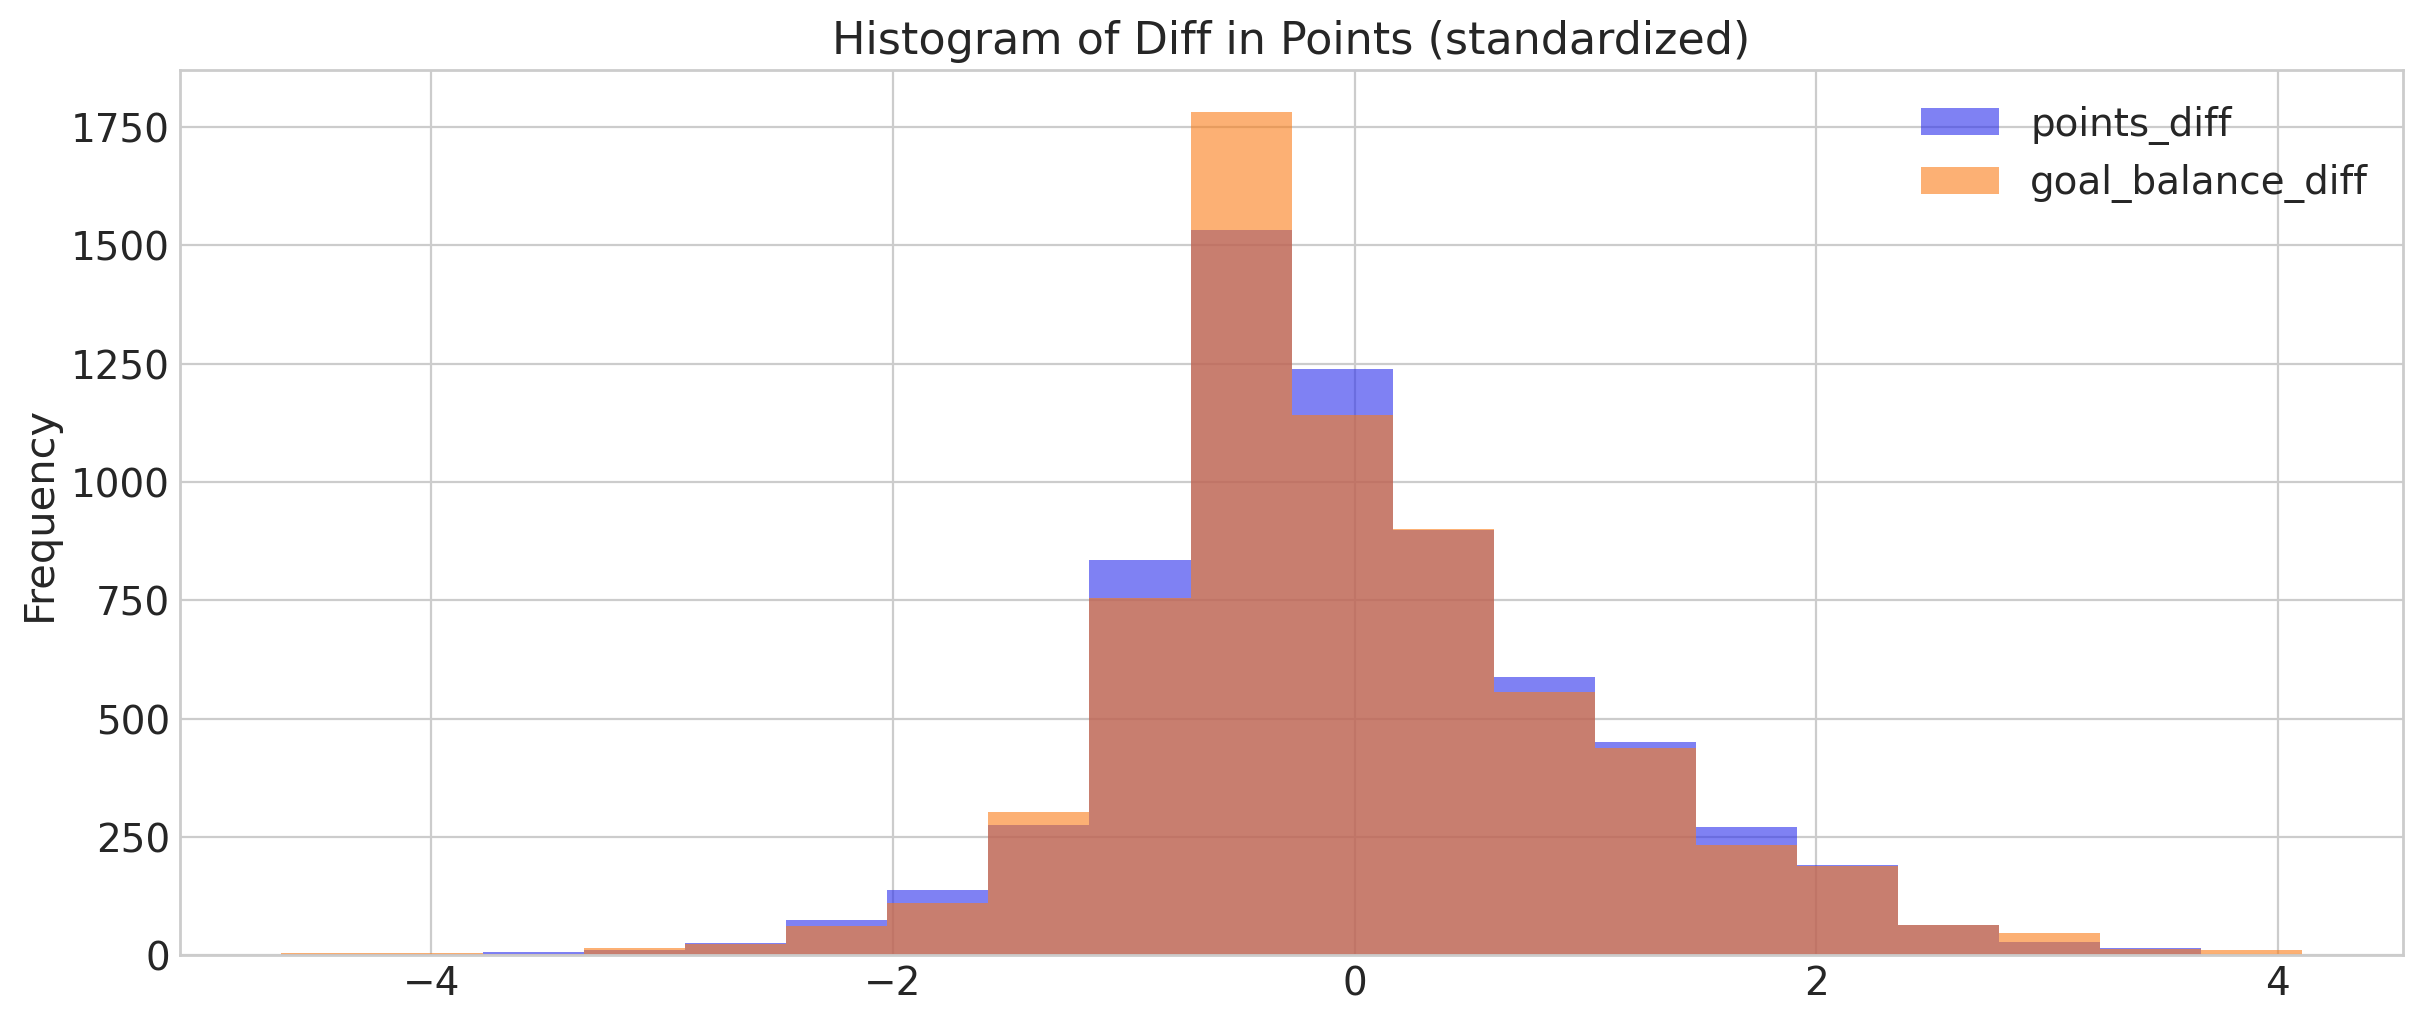

In [36]:
factors_numeric_sdz.plot(
    kind="hist", alpha=0.6, bins=20, title="Histogram of Diff in Points (standardized)"
);

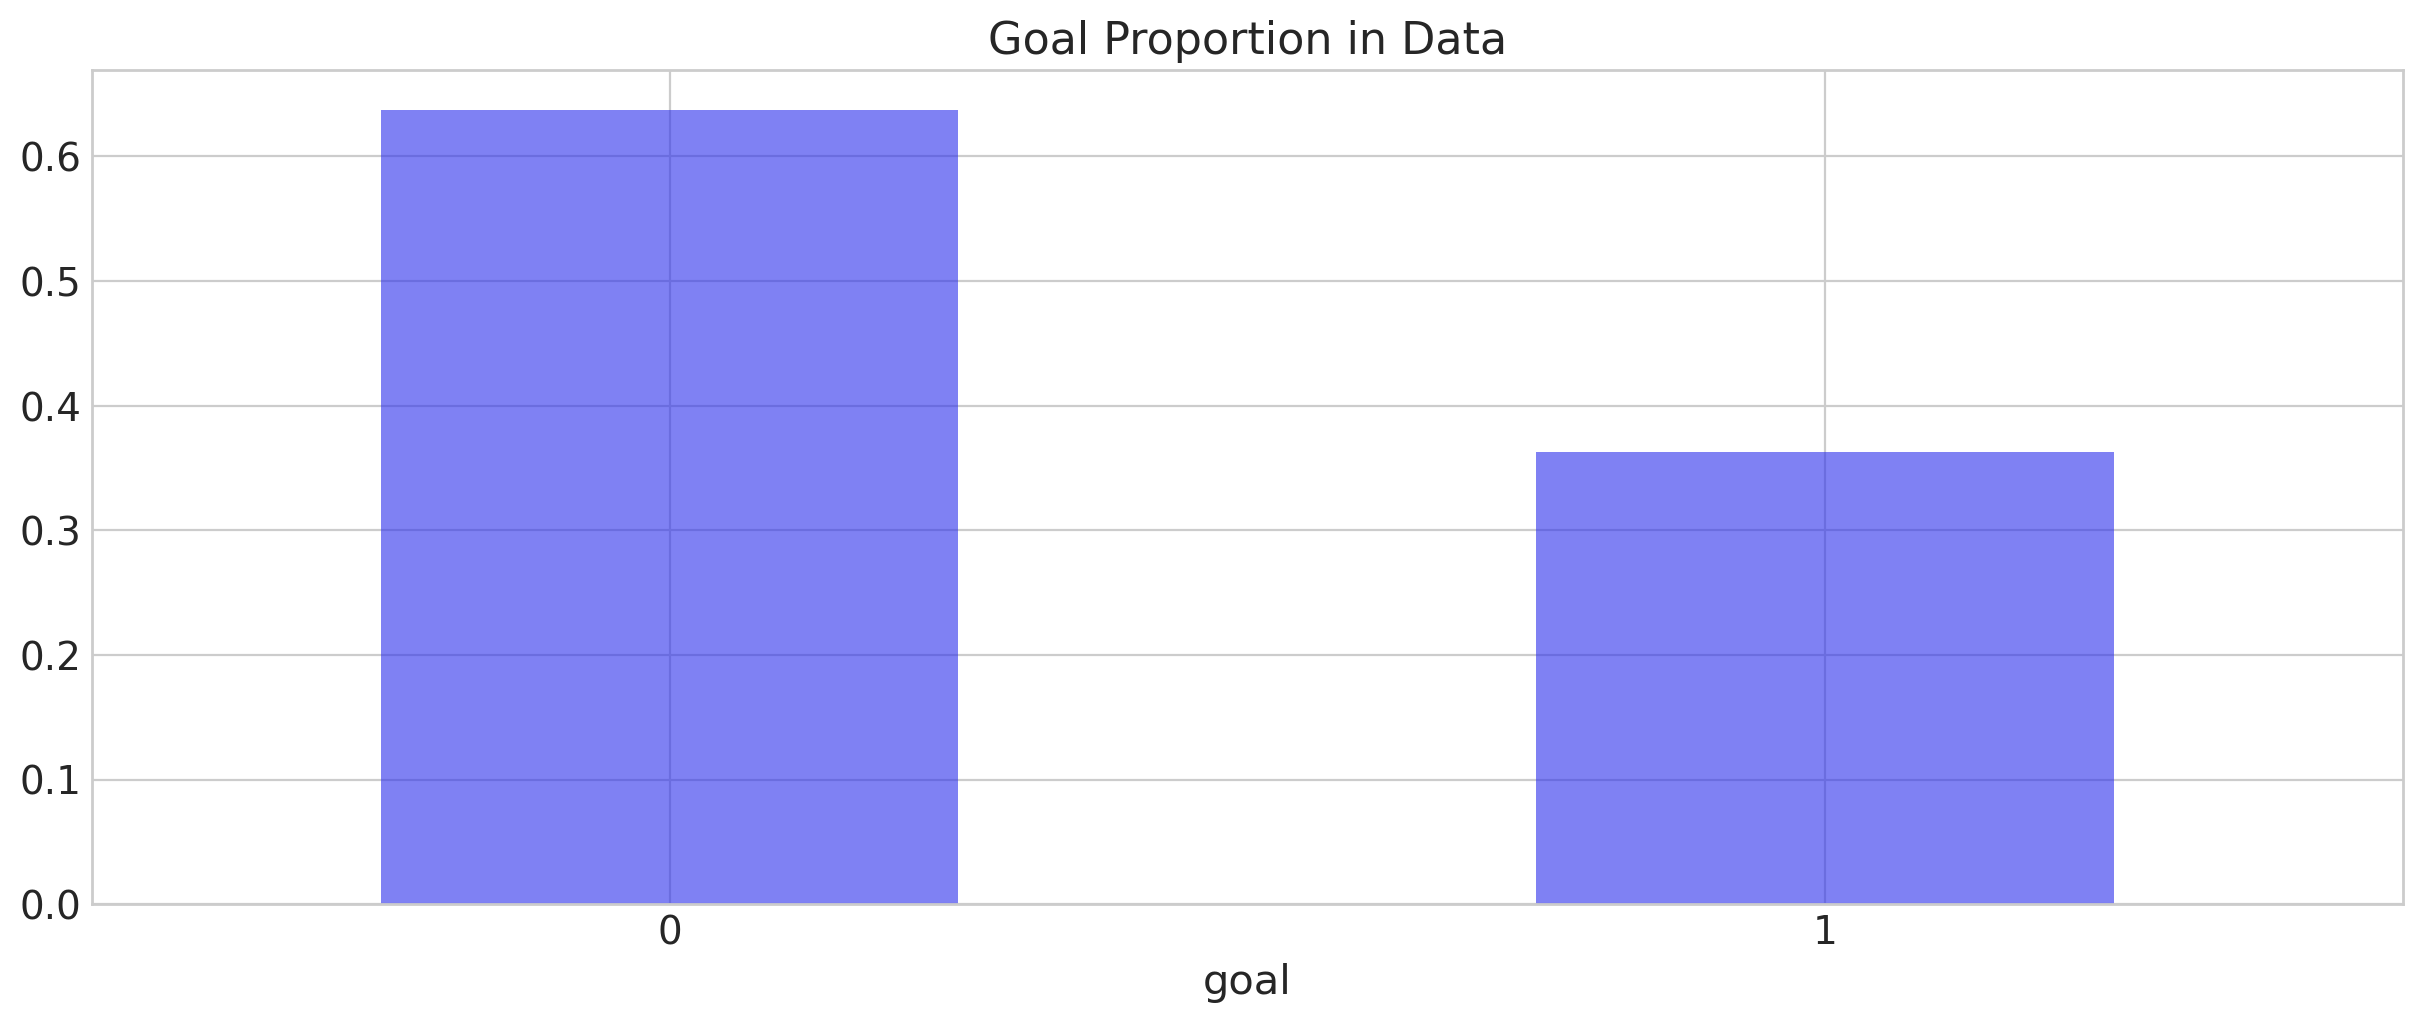

In [37]:
complete_data["goal"].value_counts(normalize=True).plot(
    alpha=0.6, kind="bar", rot=0, title="Goal Proportion in Data"
);

## HSGP Parameters

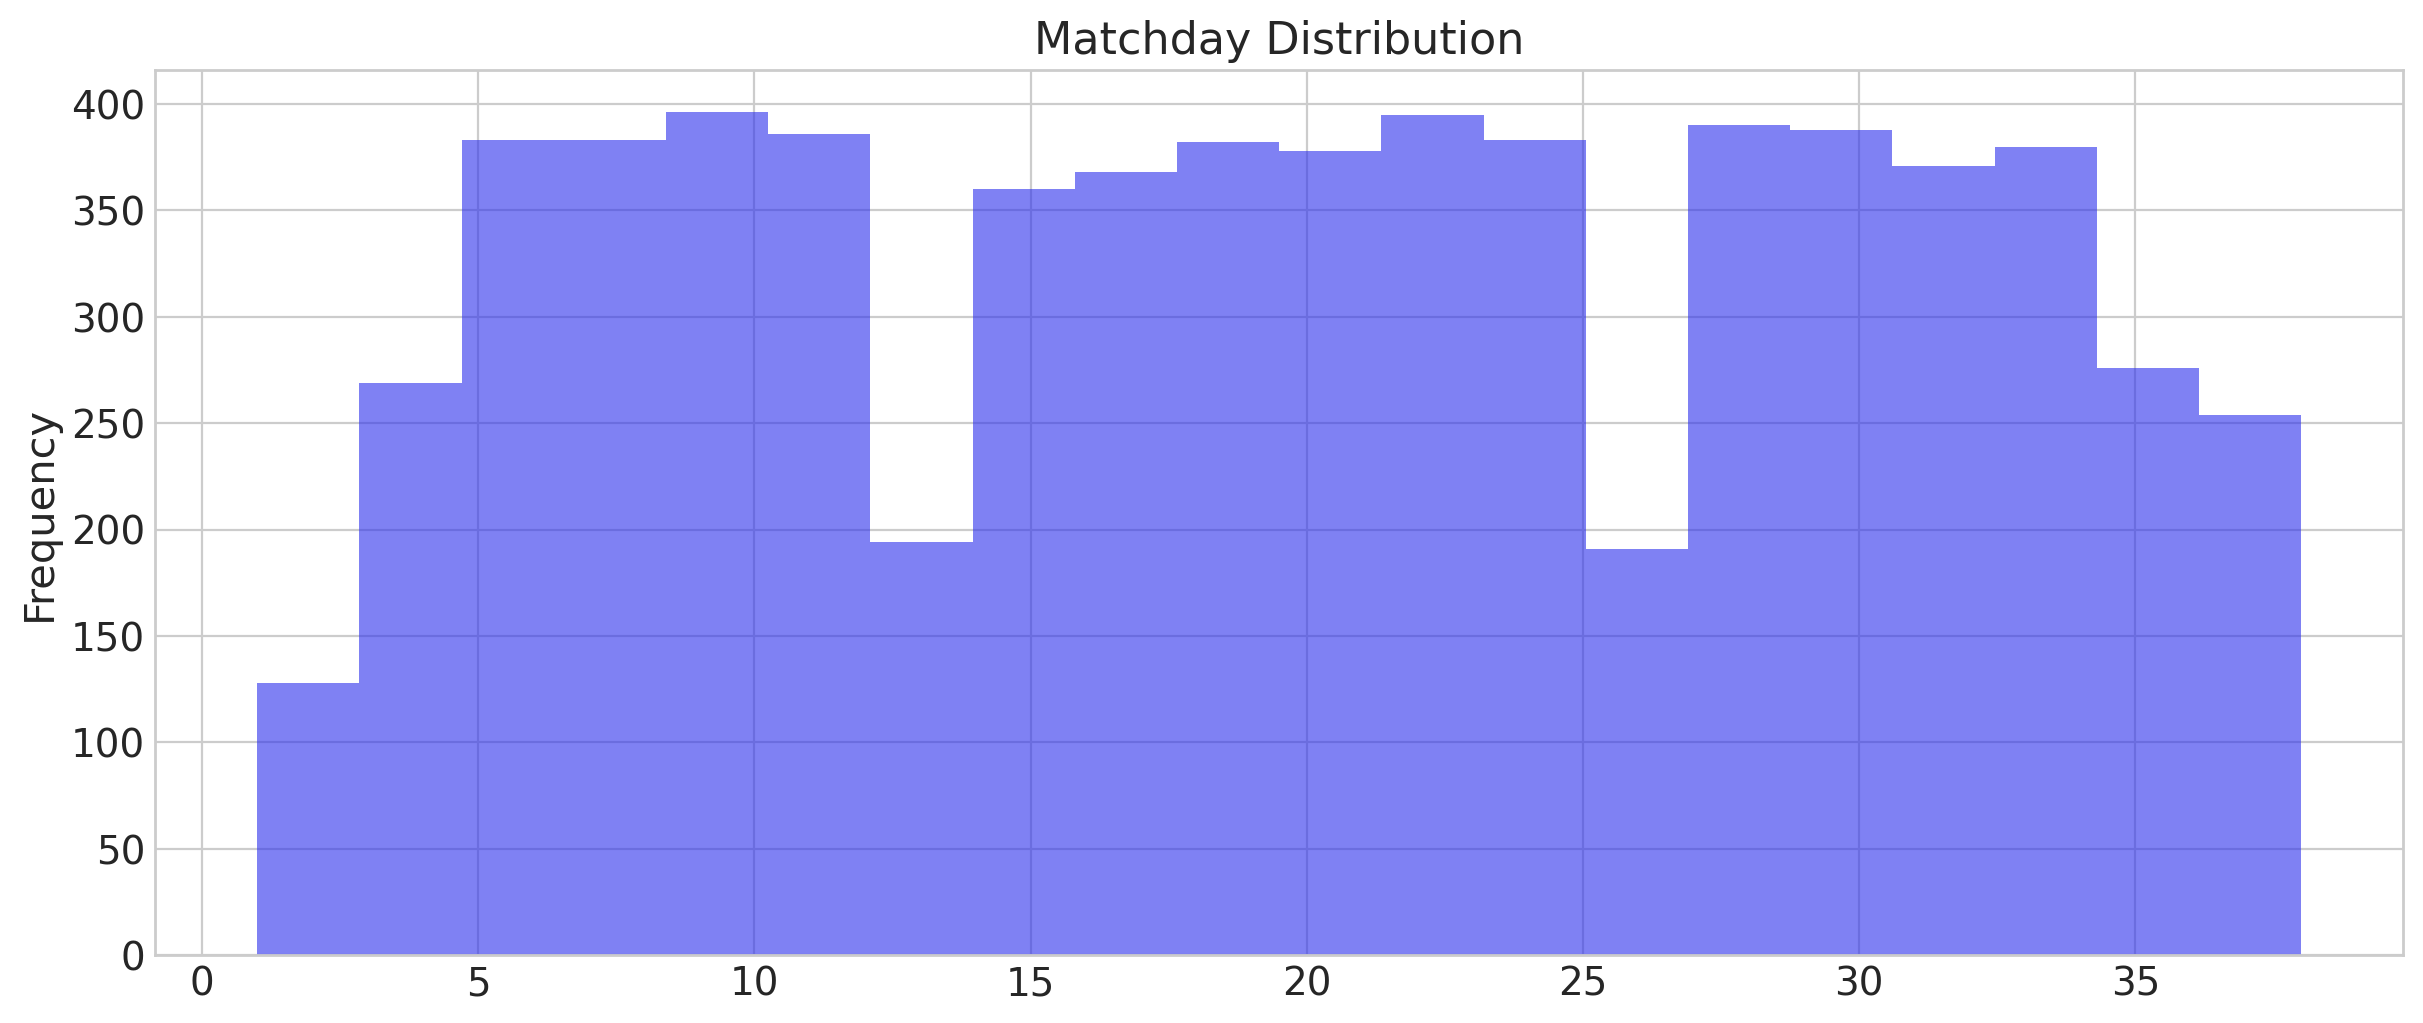

In [38]:
complete_data.matchday.plot(
    kind="hist", alpha=0.6, bins=20, title="Matchday Distribution"
);

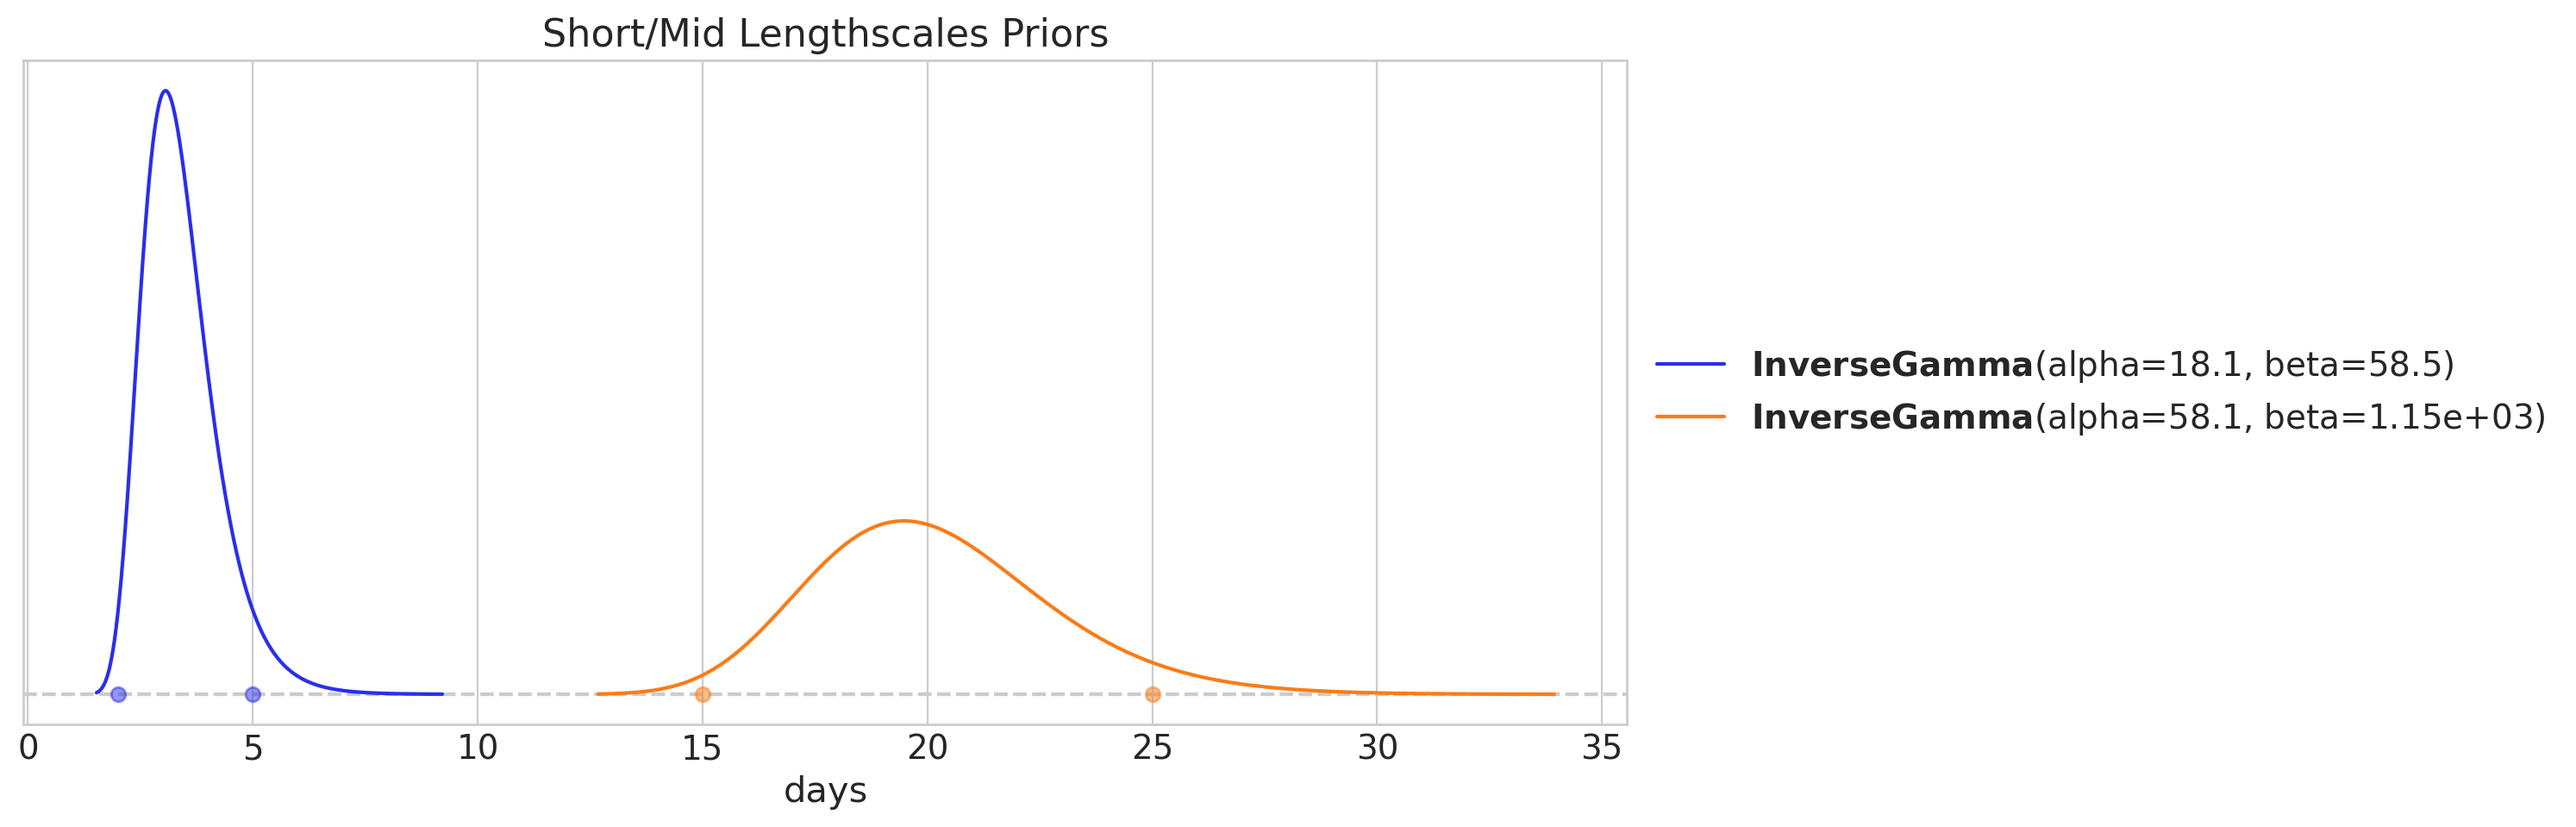

In [39]:
ls_short_dist, _ = pz.maxent(pz.InverseGamma(), 2, 5)
ls_medium_dist, ax = pz.maxent(pz.InverseGamma(), 15, 25)
ax.set(title="Short/Mid Lengthscales Priors", xlabel="days");

In [40]:
m_within, c_within = pm.gp.hsgp_approx.approx_hsgp_hyperparams(
    x_range=[0, complete_data.matchday.max()],
    lengthscale_range=[5, 25],  # nbr of matchdays with autocorrelation
    cov_func="matern52",  # our covariance function
)

print("Recommended smallest number of basis vectors (m):", m_within)
print("Recommended smallest scaling factor (c):", np.round(c_within, 1))

Recommended smallest number of basis vectors (m): 54
Recommended smallest scaling factor (c): 5.4


In [43]:
m_long, c_long = pm.gp.hsgp_approx.approx_hsgp_hyperparams(
    x_range=[0, complete_data.season_nbr.max()],
    lengthscale_range=[2, 6],
    cov_func="matern52",
)

print("Recommended smallest number of basis vectors (m):", m_long)
print("Recommended smallest scaling factor (c):", np.round(c_long, 1))

Recommended smallest number of basis vectors (m): 32
Recommended smallest scaling factor (c): 2.6


## PyMC Model

In [44]:
player_idx = pd.Categorical(
    complete_data["name_player"], categories=players_ordered
).codes

unique_gamedays = complete_data["matchday"].sort_values().unique()
gameday_idx = pd.Categorical(
    complete_data["matchday"],
    categories=unique_gamedays,
).codes

unique_seasons = complete_data["season_nbr"].unique()

coords = {
    "factor": factors,
    "gameday": unique_gamedays,
    "obs_id": complete_data.index,
    "player": players_ordered,
    "season": unique_seasons,
    "timescale": ["short", "medium", "long"],
}

In [45]:
with pm.Model(coords=coords) as SFM_rlp:
    # Data containers
    factor_data = pm.Data(
        "factor_data", factors_sdz.to_numpy(), dims=("obs_id", "factor")
    )
    gameday_id = pm.Data("gameday_id", gameday_idx, dims="obs_id")
    player_id = pm.Data("player_id", player_idx, dims="obs_id")
    season_id = pm.Data(
        "season_id", complete_data["season_nbr"].to_numpy(), dims="obs_id"
    )
    goals_obs = pm.Data("goals_obs", complete_data["goal"].to_numpy(), dims="obs_id")

In [47]:
with SFM_rlp:
    sigma = player_diversity_dist.to_pymc(name="player_diversity")
    player_effect = pm.Normal(
        "player_effect",
        mu=logit(complete_data["goal"].mean()),
        sigma=sigma,
        dims="player",
    )

In [48]:
with SFM_rlp:
    X_gamedays = pm.Data("X_gamedays", unique_gamedays, dims="gameday")[:, None]
    X_seasons = pm.Data("X_seasons", unique_seasons, dims="season")[:, None]

    ## PC prior on amplitude
    # 1% chance that amplitude > sigmoid(1.1)=0.75%
    alpha_scale, upper_scale = 0.01, 1.1
    amplitude = pm.Exponential(
        "amplitude", lam=-np.log(alpha_scale) / upper_scale, dims="timescale"
    )
    ls = pm.InverseGamma(
        "ls",
        alpha=np.array([ls_short_dist.alpha, ls_medium_dist.alpha, ls_long_dist.alpha]),
        beta=np.array([ls_short_dist.beta, ls_medium_dist.beta, ls_long_dist.beta]),
        dims="timescale",
    )

    # cov matrices
    cov_short = amplitude[0] ** 2 * pm.gp.cov.Matern52(input_dim=1, ls=ls[0])
    cov_medium = amplitude[1] ** 2 * pm.gp.cov.Matern52(input_dim=1, ls=ls[1])
    cov_within = cov_short + cov_medium
    cov_long = amplitude[2] ** 2 * pm.gp.cov.Matern52(input_dim=1, ls=ls[2])

    ## define GPs
    gp_within = pm.gp.HSGP(
        m=[m_within],
        c=c_within,
        cov_func=cov_within,
        drop_first=True,
    )
    f_within = gp_within.prior(
        "f_within",
        X=X_gamedays,
        hsgp_coeffs_dims="basis_coeffs_within",
        dims="gameday",
    )

    ## using .prior_linearized, just for demo
    gp_long = pm.gp.HSGP(m=[m_long], c=c_long, cov_func=cov_long, drop_first=True)
    basis_vectors_long, sqrt_psd_long = gp_long.prior_linearized(X=X_seasons)
    basis_coeffs_long = pm.Normal(
        "basis_coeffs_long", shape=gp_long.n_basis_vectors - 1
    )
    # non-centered parameterization
    f_long = pm.Deterministic(
        "f_long",
        basis_vectors_long @ (basis_coeffs_long * sqrt_psd_long),
        dims="season",
    )

In [49]:
with SFM_rlp:
    alpha = pm.Deterministic(
        "alpha",
        player_effect[player_id] + f_within[gameday_id] + f_long[season_id],
        dims="obs_id",
    )

In [50]:
with SFM_rlp:
    slope = pm.Normal("slope", sigma=0.25, dims="factor")

In [51]:
with SFM_rlp:
    # regression
    p = pm.Deterministic(
        "p", pm.math.sigmoid(alpha + pm.math.dot(factor_data, slope)), dims="obs_id"
    )

    # likelihood
    pm.Bernoulli(
        "goals_scored",
        p=p,
        observed=goals_obs,
        dims="obs_id",
    )

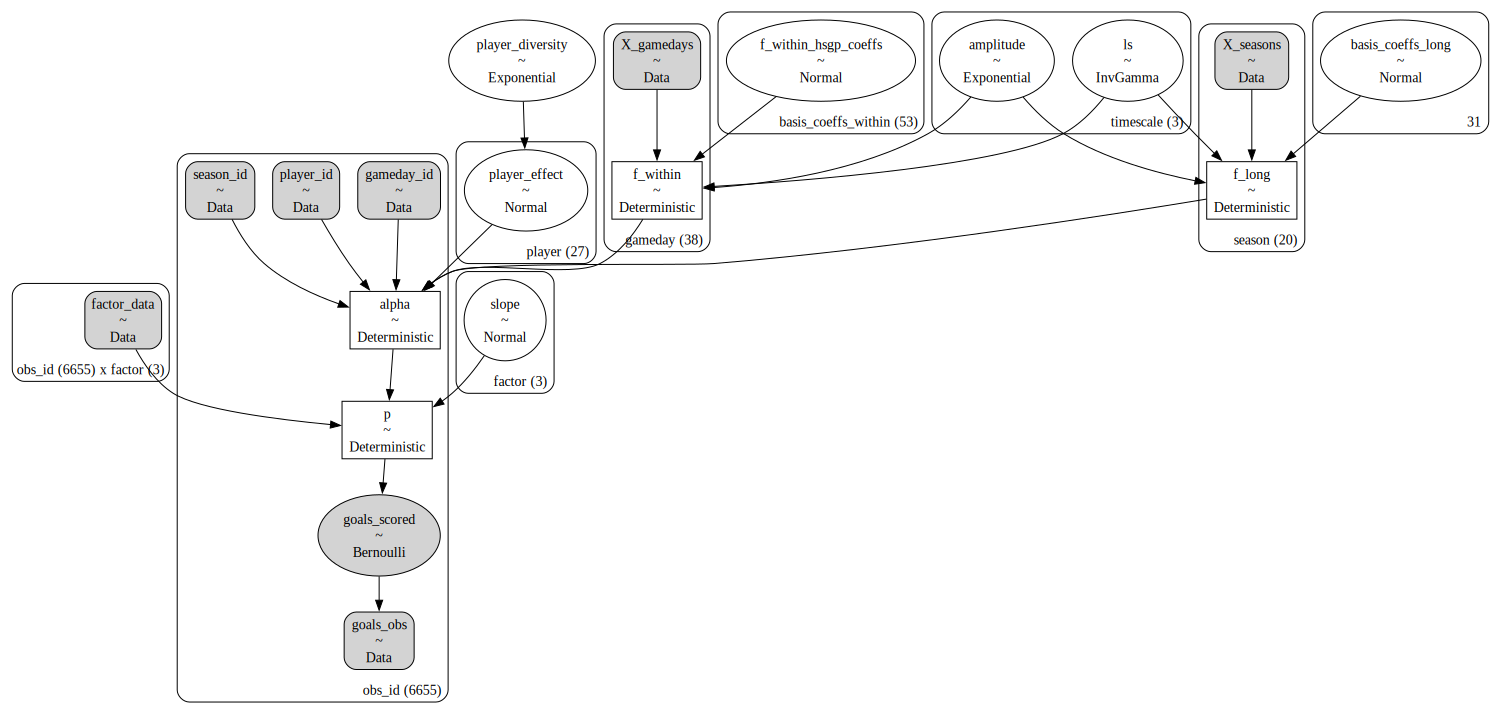

In [52]:
pm.model_to_graphviz(SFM_rlp)

## Prior Predictive Sampling

In [53]:
with SFM_rlp:
    idata = pm.sample_prior_predictive(random_seed=rng)

Sampling: [amplitude, basis_coeffs_long, f_within_hsgp_coeffs, goals_scored, ls, player_diversity, player_effect, slope]


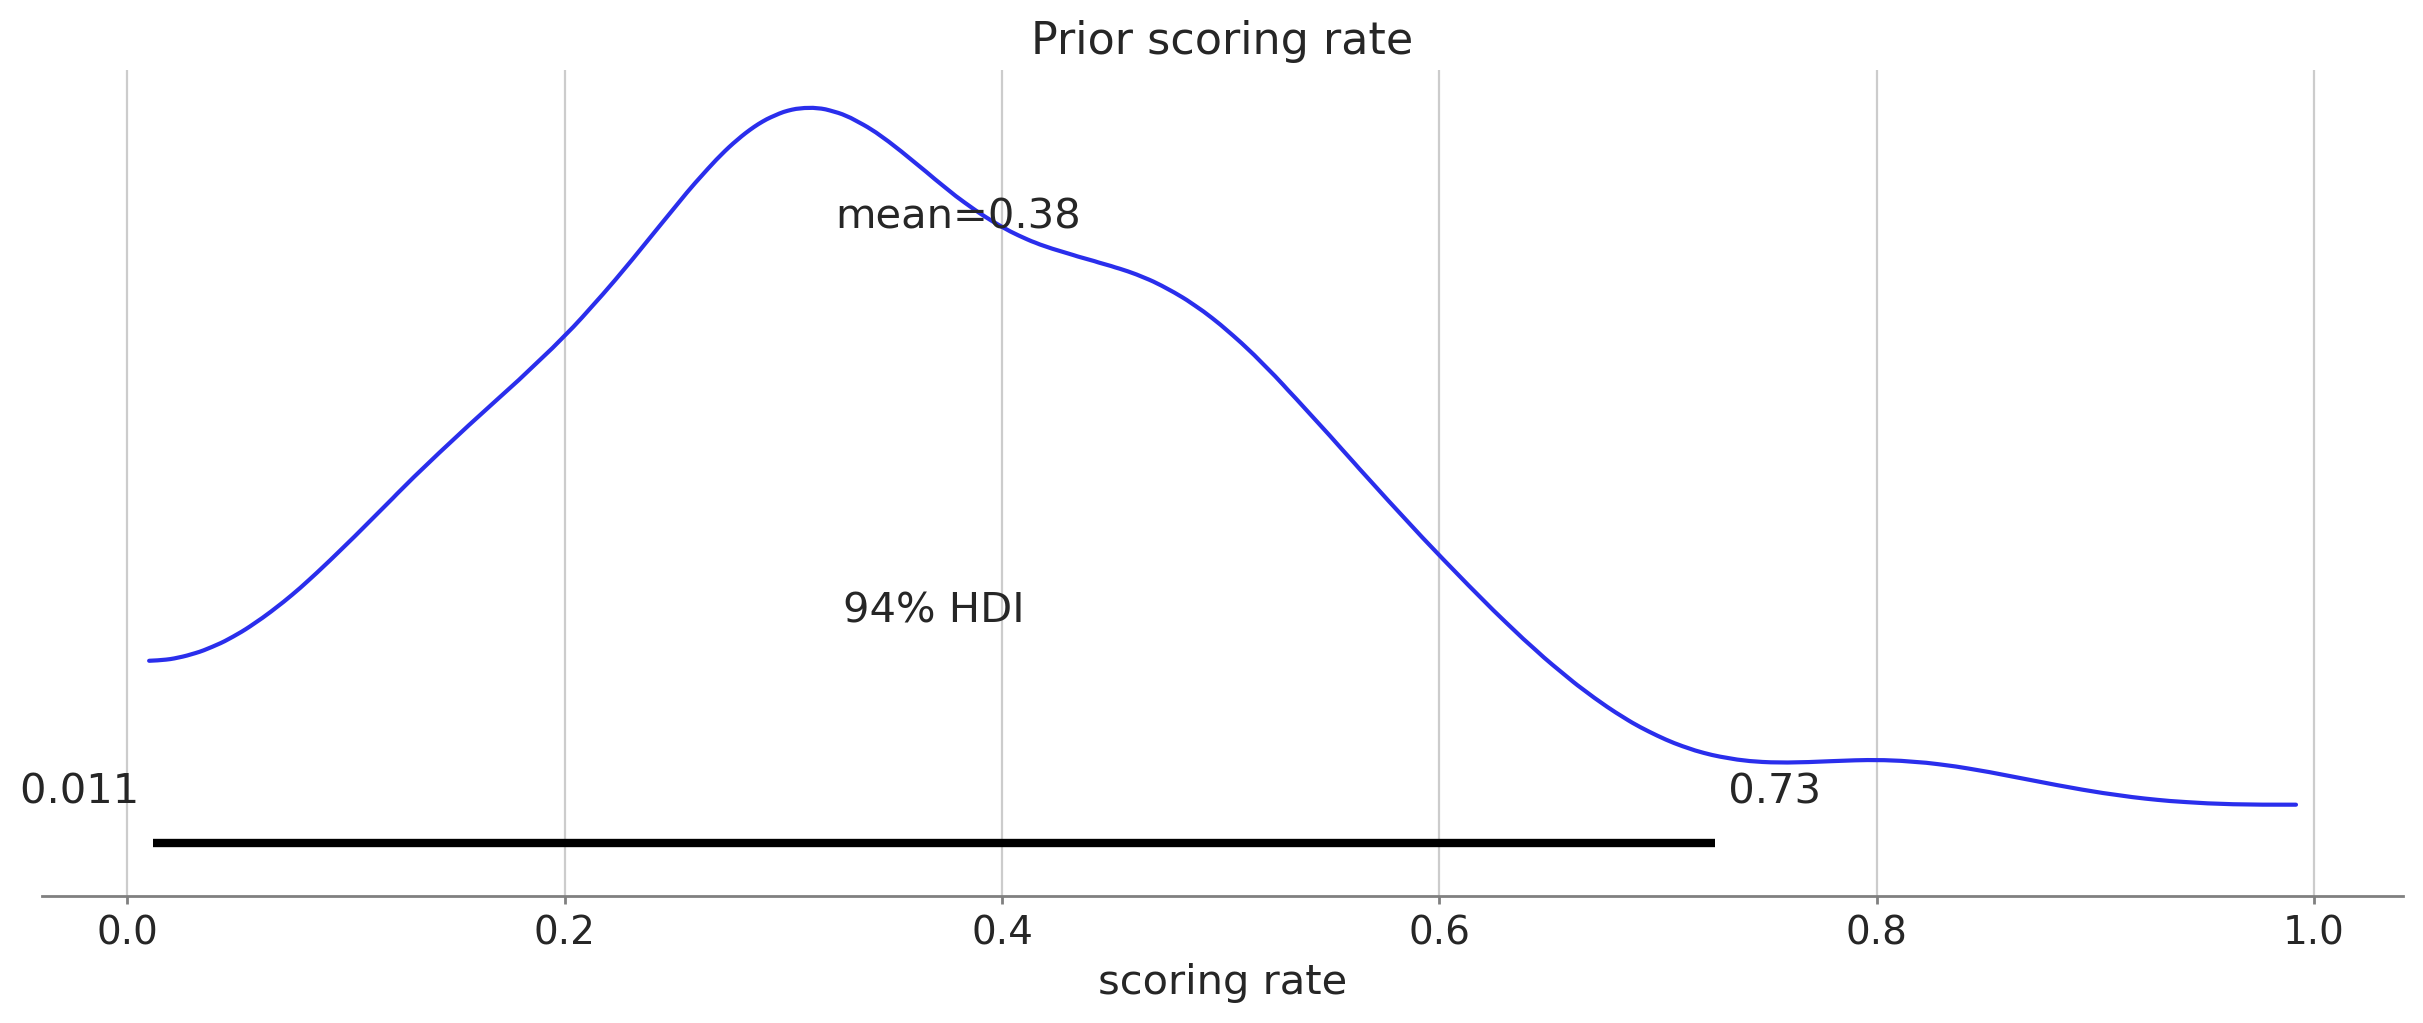

In [54]:
ax = az.plot_posterior(idata.prior.p.sel(obs_id=0))
ax.set(
    xlabel="scoring rate",
    title="Prior scoring rate",
);

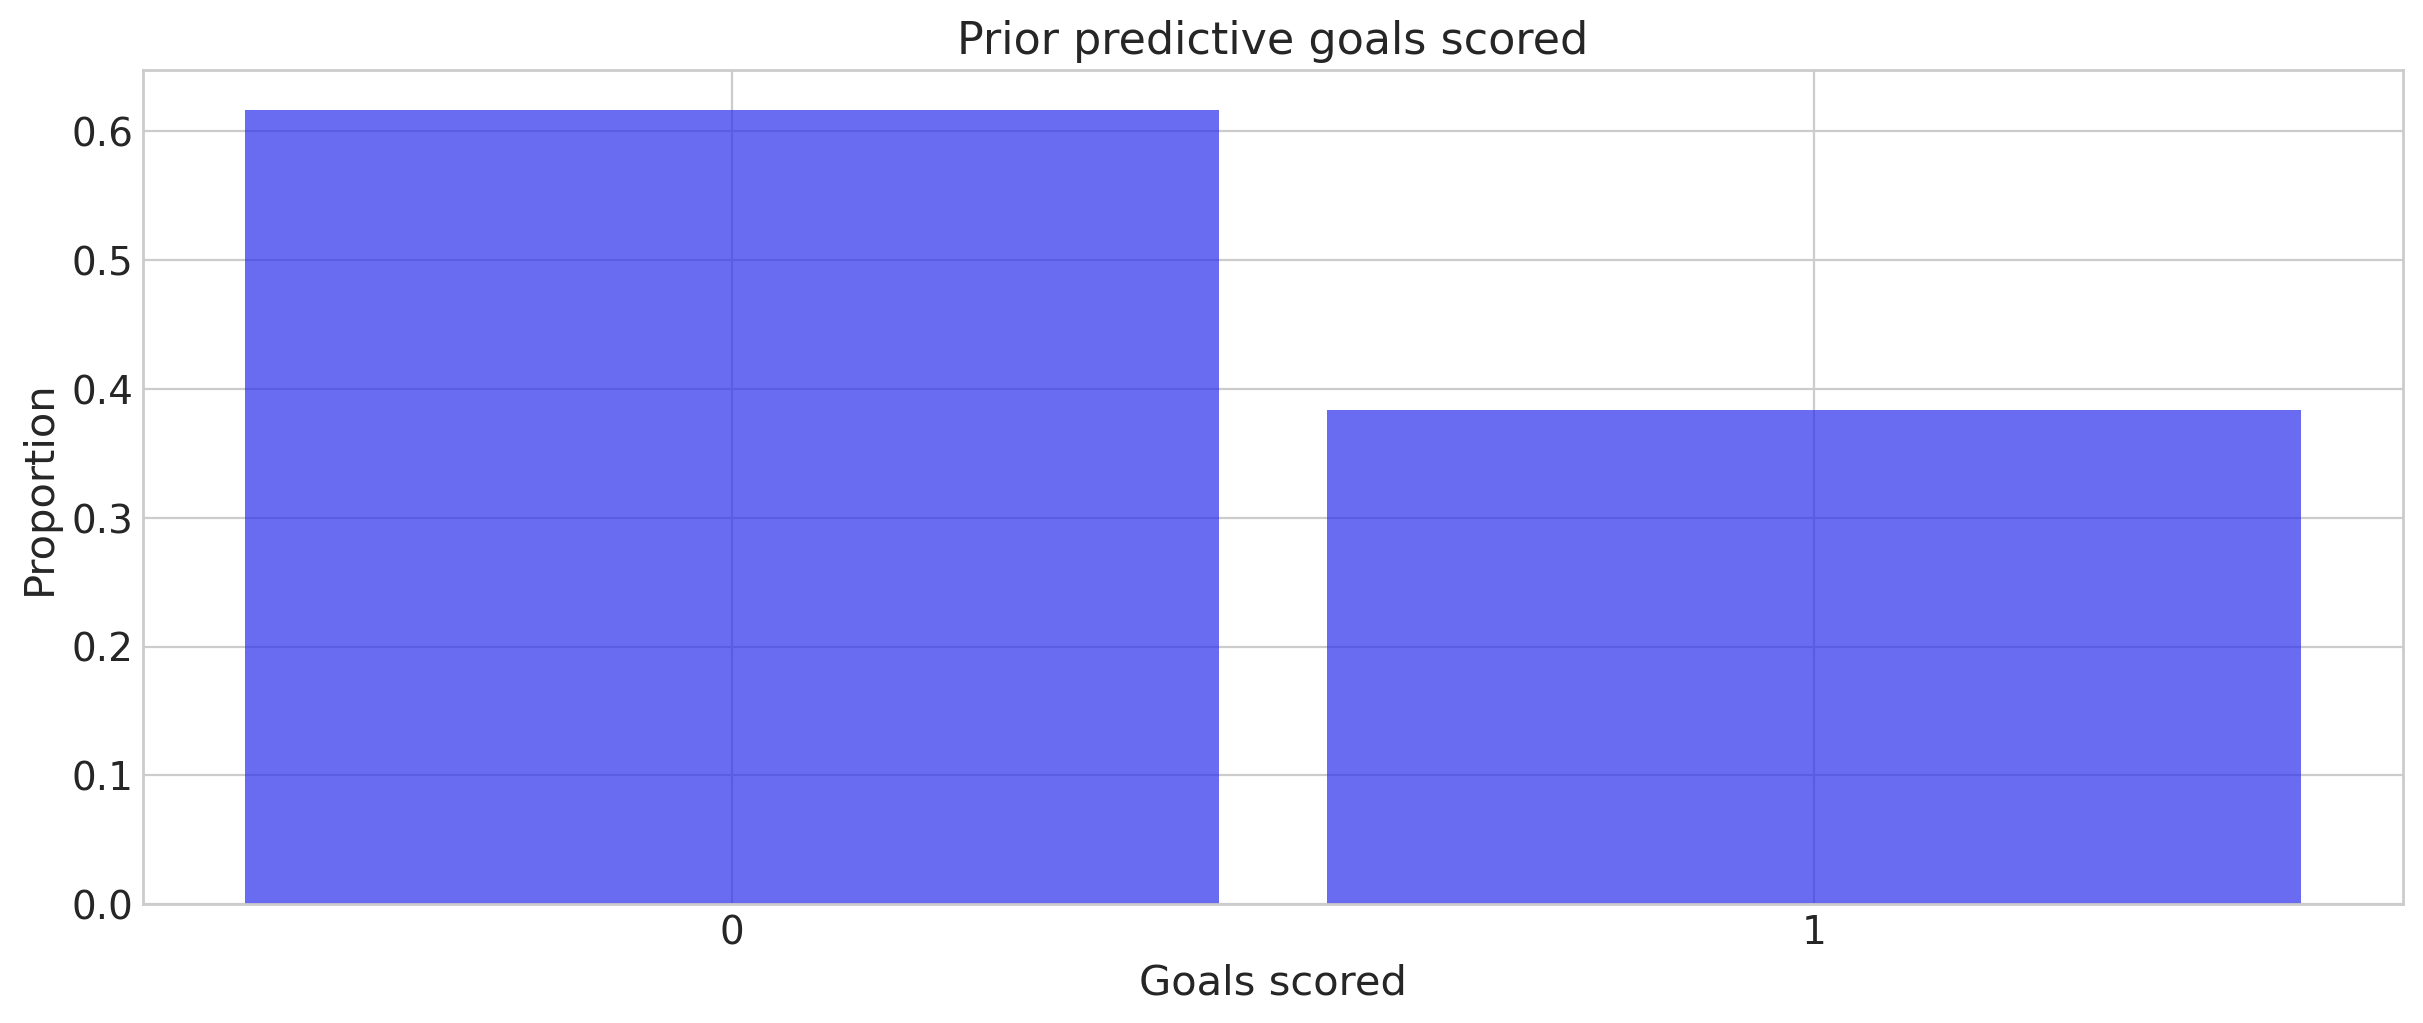

In [55]:
ax = az.plot_dist(
    idata.prior_predictive.goals_scored,
    hist_kwargs={"alpha": 0.7},
)
ax.set(
    xlabel="Goals scored", title="Prior predictive goals scored", ylabel="Proportion"
);

In [56]:
f_within_prior = idata.prior["f_within"]
f_long_prior = idata.prior["f_long"]

index = pd.MultiIndex.from_product(
    [unique_seasons, unique_gamedays],
    names=["season_nbr", "gameday"],
)
unique_combinations = pd.DataFrame(index=index).reset_index()

f_long_prior_aligned = f_long_prior.sel(
    season=unique_combinations["season_nbr"].to_numpy()
).rename({"season": "timestamp"})
f_long_prior_aligned["timestamp"] = unique_combinations.index

f_within_prior_aligned = f_within_prior.sel(
    gameday=unique_combinations["gameday"].to_numpy()
).rename({"gameday": "timestamp"})
f_within_prior_aligned["timestamp"] = unique_combinations.index

f_total_prior = f_long_prior_aligned + f_within_prior_aligned

some_draws = rng.choice(f_total_prior.draw, size=20, replace=True)

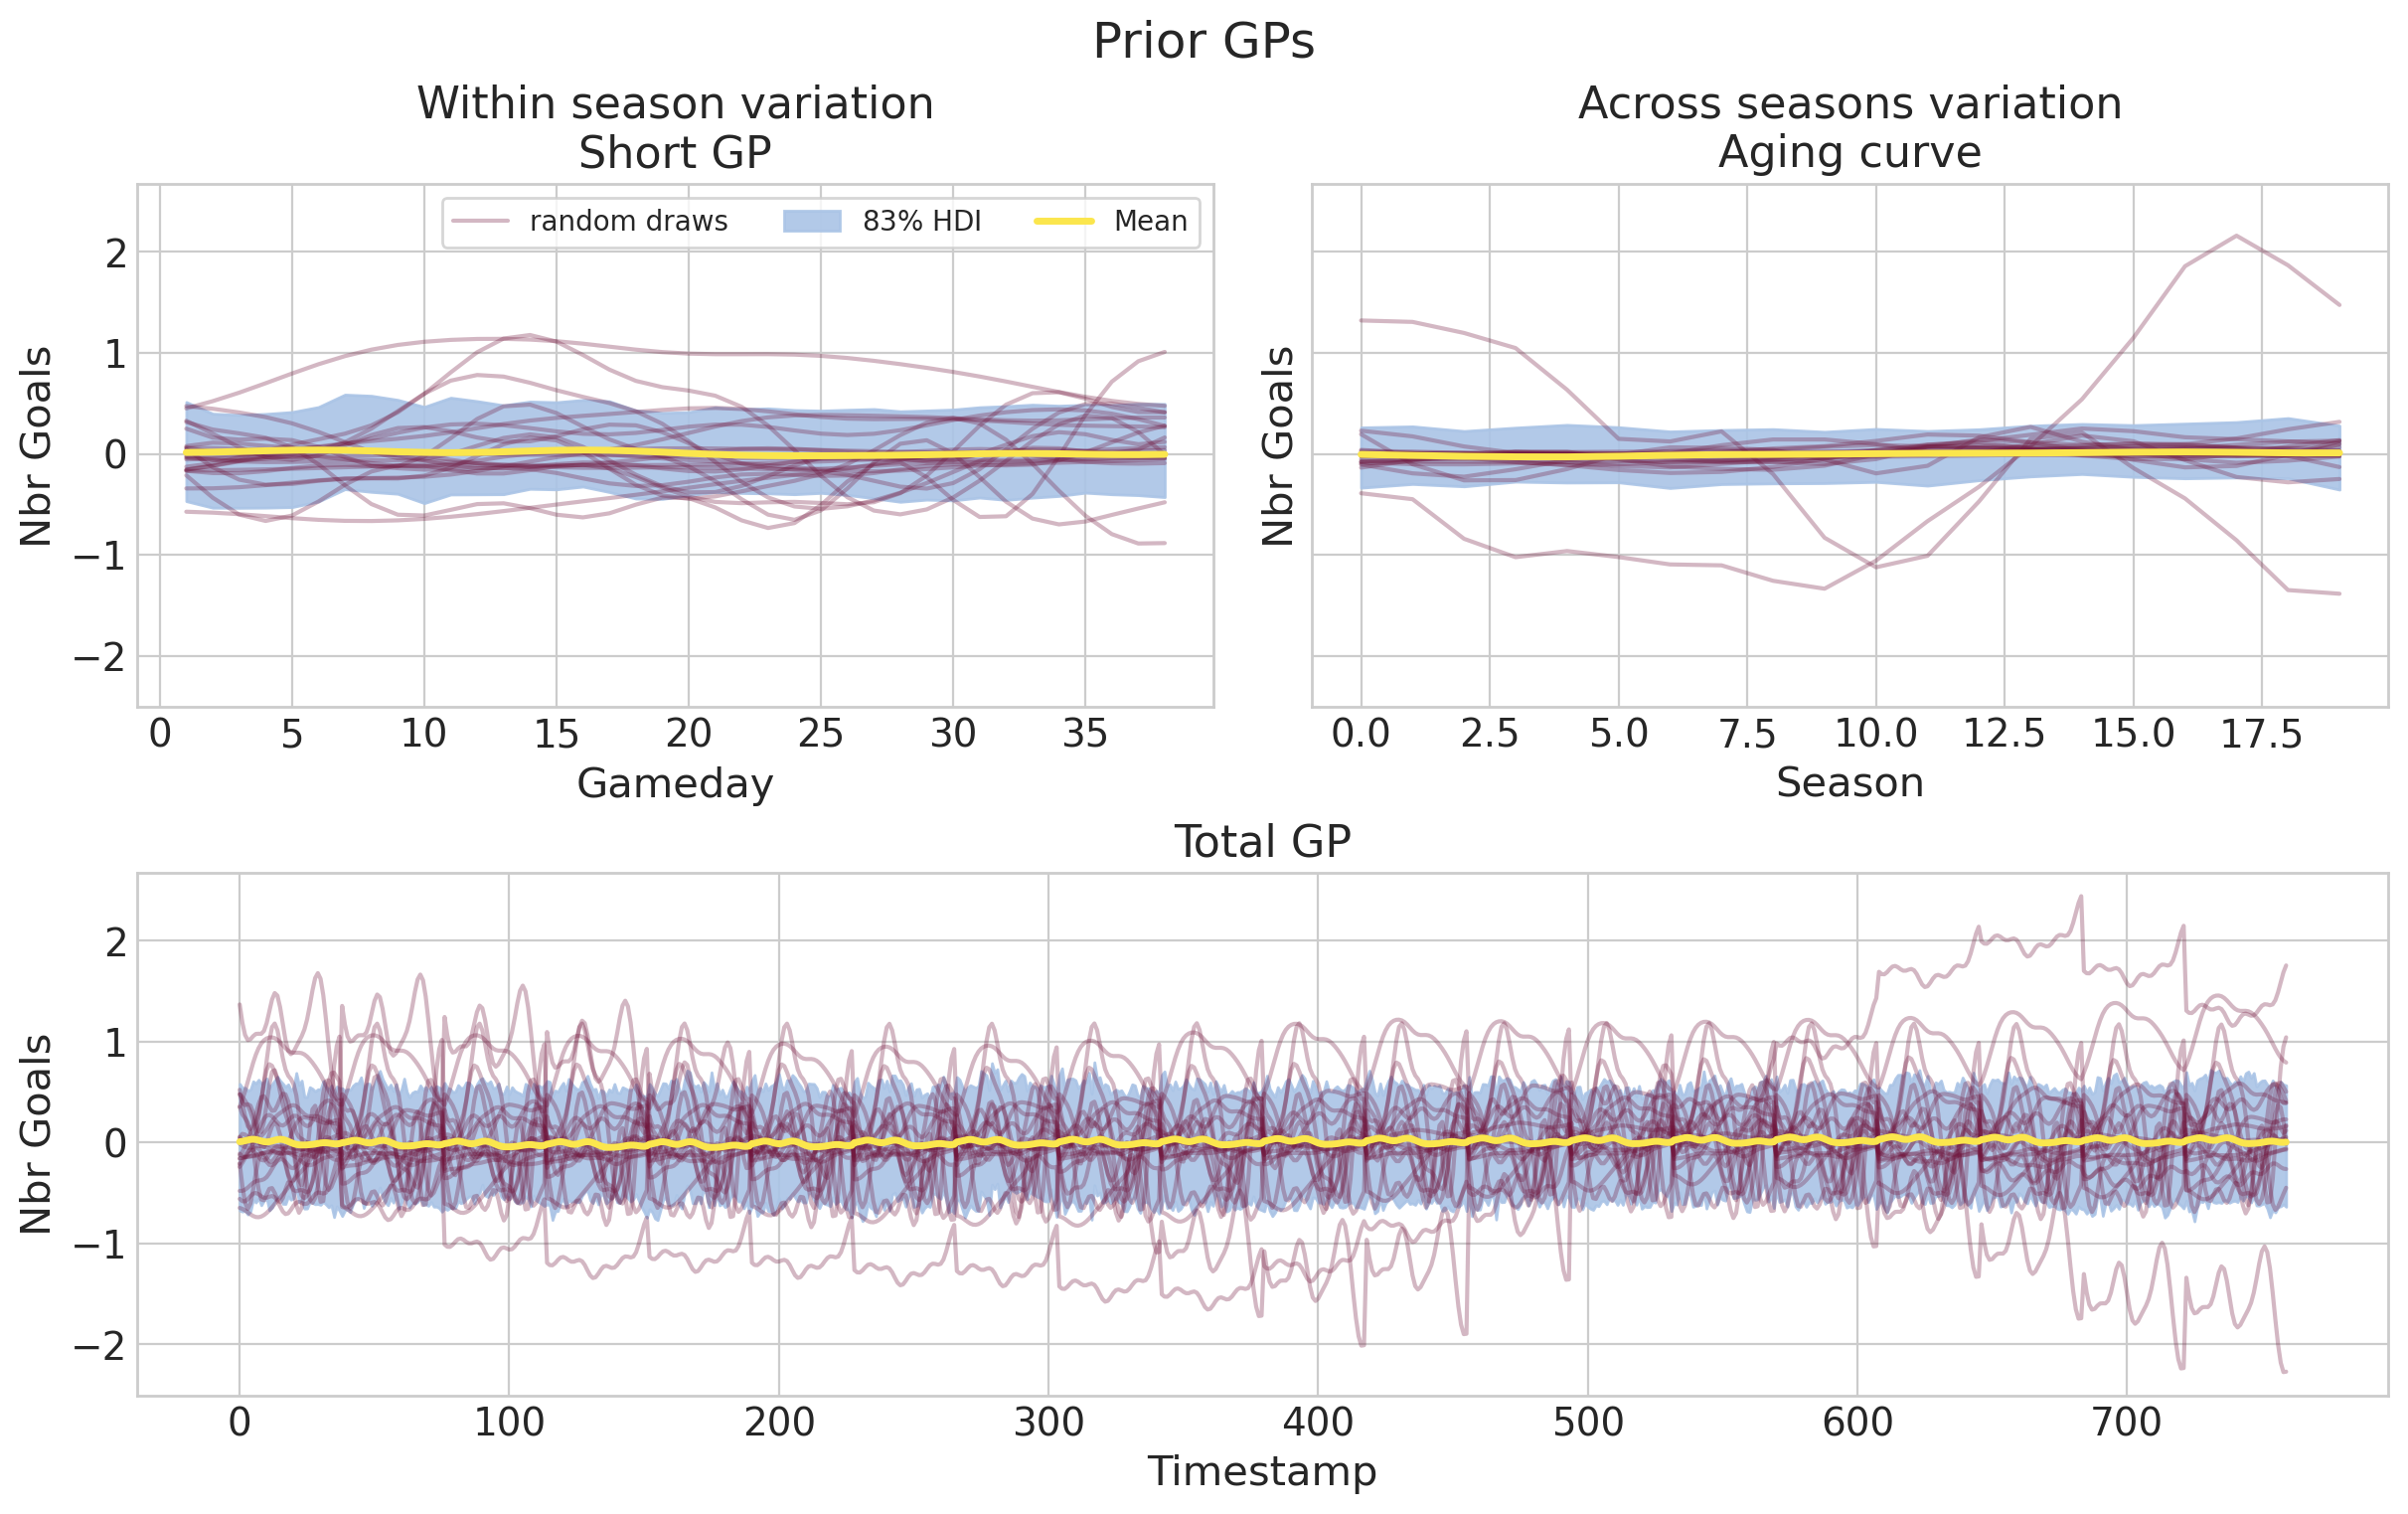

In [57]:
_, axes = plt.subplot_mosaic(
    """
    AB
    CC
    """,
    figsize=(12, 7.5),
    layout="constrained",
    sharey=True,
)

axes["A"].plot(
    f_within_prior.gameday,
    az.extract(f_within_prior)["f_within"].isel(sample=0),
    color="#70133A",
    alpha=0.3,
    lw=1.5,
    label="random draws",
)
axes["A"].plot(
    f_within_prior.gameday,
    az.extract(f_within_prior)["f_within"].isel(sample=some_draws),
    color="#70133A",
    alpha=0.3,
    lw=1.5,
)
az.plot_hdi(
    x=f_within_prior.gameday,
    y=f_within_prior,
    hdi_prob=0.83,
    color="#AAC4E6",
    fill_kwargs={"alpha": 0.9, "label": r"$83\%$ HDI"},
    ax=axes["A"],
    smooth=False,
)
axes["A"].plot(
    f_within_prior.gameday,
    f_within_prior.mean(("chain", "draw")),
    color="#FBE64D",
    lw=2.5,
    label="Mean",
)
axes["A"].set(
    xlabel="Gameday", ylabel="Nbr Goals", title="Within season variation\nShort GP"
)
axes["A"].legend(fontsize=10, frameon=True, ncols=3)

axes["B"].plot(
    f_long_prior.season,
    az.extract(f_long_prior)["f_long"].isel(sample=some_draws),
    color="#70133A",
    alpha=0.3,
    lw=1.5,
)
az.plot_hdi(
    x=f_long_prior.season,
    y=f_long_prior,
    hdi_prob=0.83,
    color="#AAC4E6",
    fill_kwargs={"alpha": 0.9},
    ax=axes["B"],
    smooth=False,
)
axes["B"].plot(
    f_long_prior.season,
    f_long_prior.mean(("chain", "draw")),
    color="#FBE64D",
    lw=2.5,
)
axes["B"].set(
    xlabel="Season", ylabel="Nbr Goals", title="Across seasons variation\nAging curve"
)

axes["C"].plot(
    f_total_prior.timestamp,
    az.extract(f_total_prior)["x"].isel(sample=some_draws),
    color="#70133A",
    alpha=0.3,
    lw=1.5,
)
az.plot_hdi(
    x=f_total_prior.timestamp,
    y=f_total_prior,
    hdi_prob=0.83,
    color="#AAC4E6",
    fill_kwargs={"alpha": 0.9},
    ax=axes["C"],
    smooth=False,
)
axes["C"].plot(
    f_total_prior.timestamp,
    f_total_prior.mean(("chain", "draw")),
    color="#FBE64D",
    lw=2.5,
)
axes["C"].set(xlabel="Timestamp", ylabel="Nbr Goals", title="Total GP")
plt.suptitle("Prior GPs", fontsize=18);

## Sampling and convergence checks

In [29]:
with SFM_rlp:
    idata.extend(pm.sample(nuts_sampler="numpyro", random_seed=rng, target_accept=0.95))
    idata.extend(
        pm.sample_posterior_predictive(
            idata, random_seed=rng, compile_kwargs={"mode": "NUMBA"}
        )
    )

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
Sampling: [goals_scored]


Output()

In [30]:
ess = az.ess(idata.posterior)
ess.quantile([0.01, 0.5, 0.99]).to_dataframe().astype(int).style.background_gradient(
    axis=None, cmap="RdYlGn"
)

,player_effect,f_within_hsgp_coeffs,basis_coeffs_long,slope,player_diversity,amplitude,ls,f_within,f_long,alpha,p
quantile,,,,,,,,,,,
0.010000,878,2844,2024,3371,2124,815,3525,720,1302,3551,3651
0.500000,1526,5718,5365,3394,2124,1239,4588,807,2056,5512,5399
0.990000,2660,7136,6380,4775,2124,2364,6030,1335,4427,6934,6812


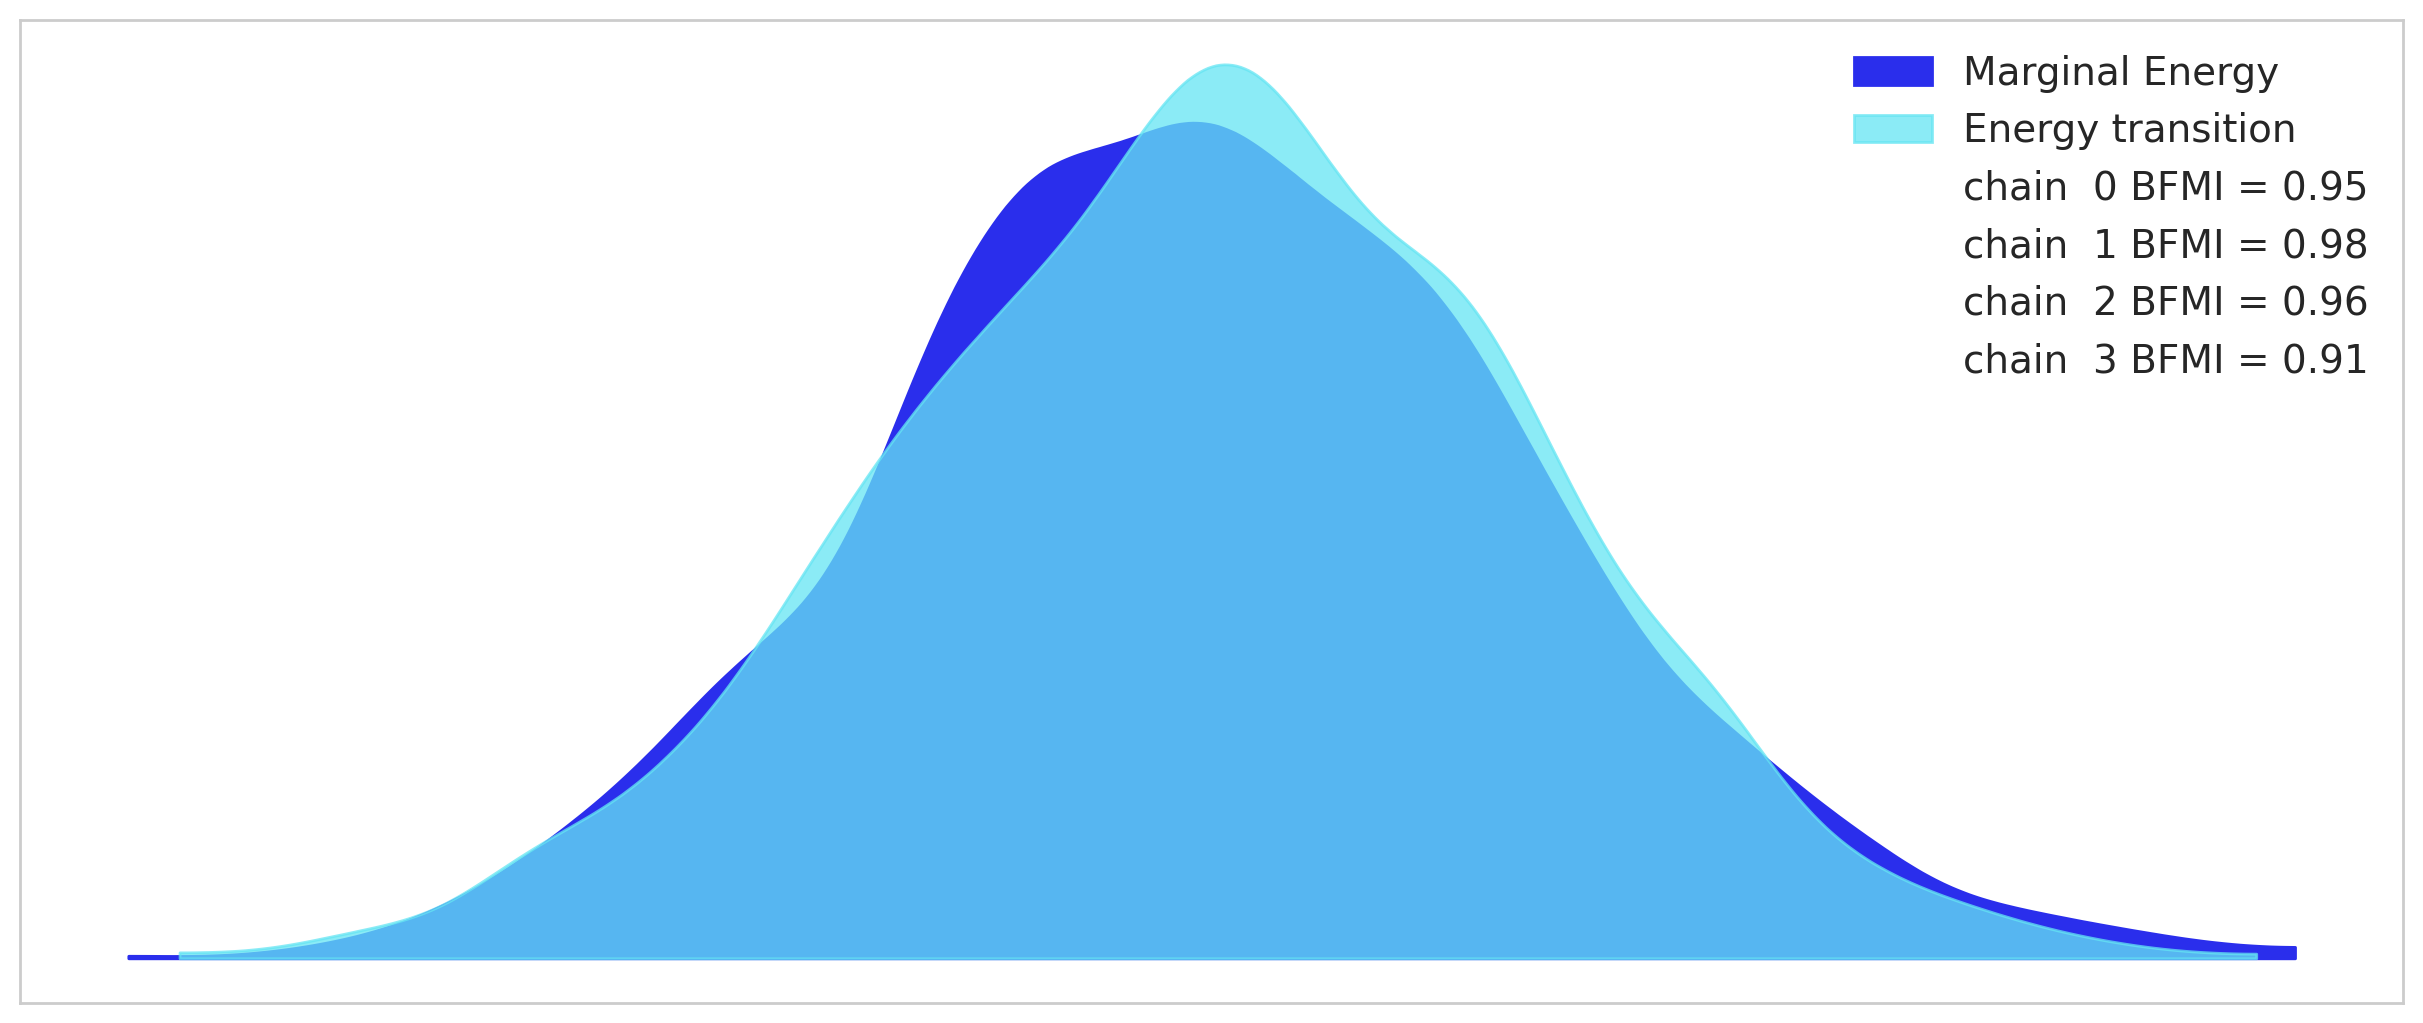

In [32]:
az.plot_energy(idata);

## Posterior parameters

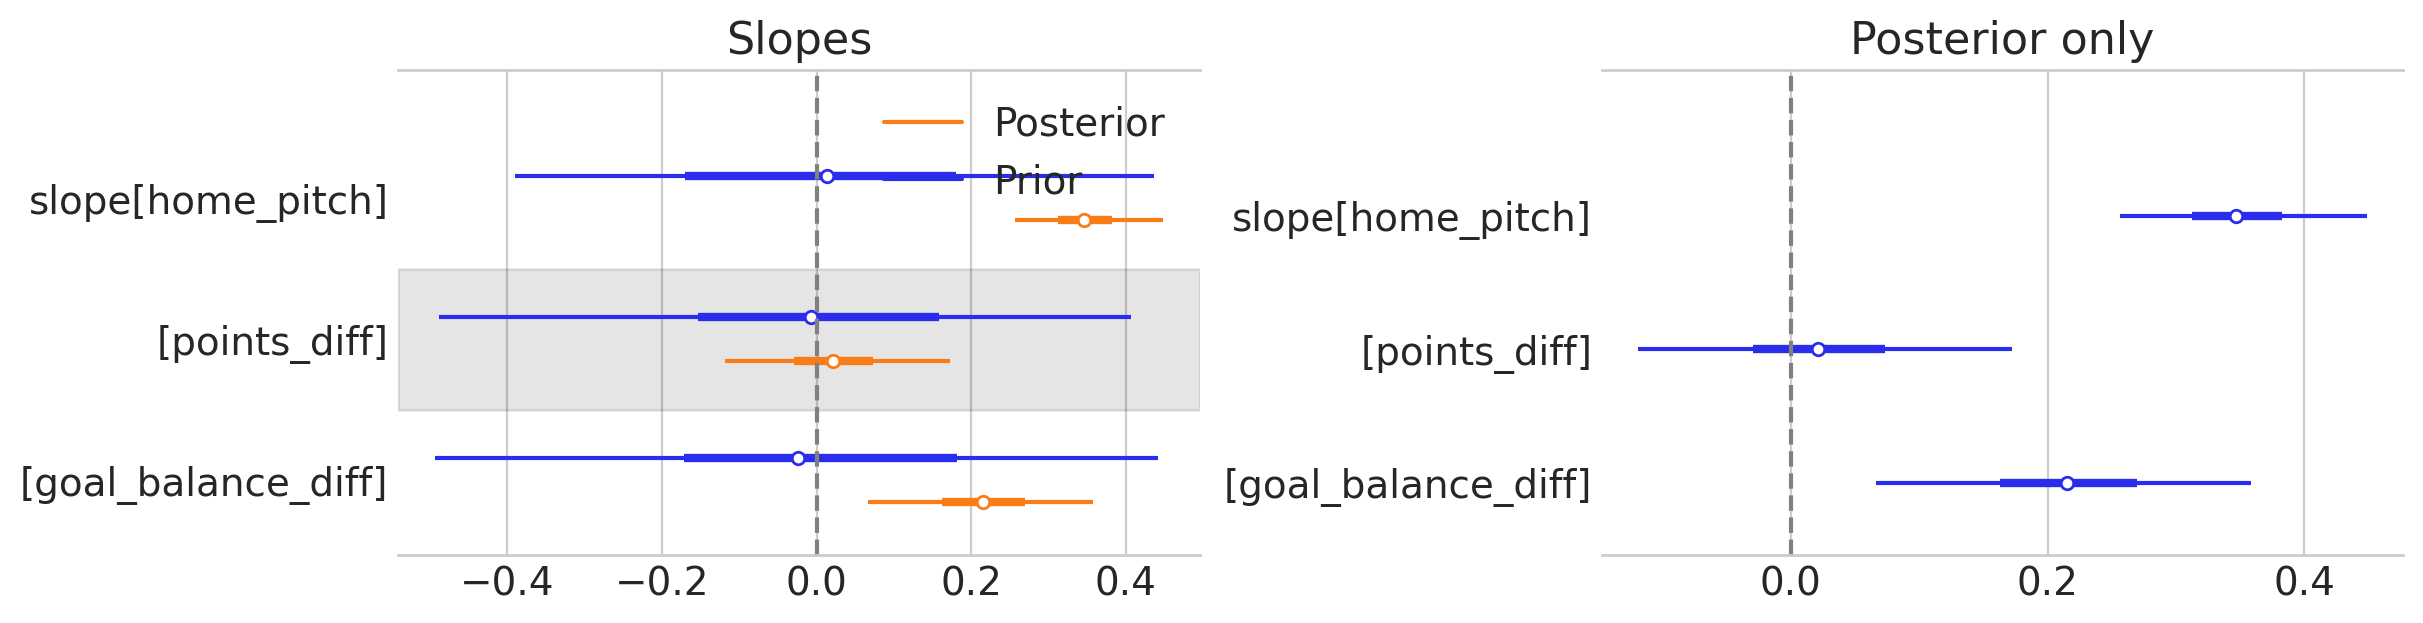

In [34]:
_, axes = plt.subplot_mosaic(
    """
    AB
    """,
    figsize=(12, 3),
    layout="constrained",
)

az.plot_forest(
    [idata.prior, idata.posterior],
    model_names=["Prior", "Posterior"],
    var_names=["slope"],
    combined=True,
    ax=axes["A"],
)
axes["A"].axvline(c="grey", ls="--")
axes["A"].set(title="Slopes")

az.plot_forest(
    idata,
    var_names=["slope"],
    combined=True,
    ax=axes["B"],
)
axes["B"].axvline(c="grey", ls="--")
axes["B"].set(title="Posterior only");

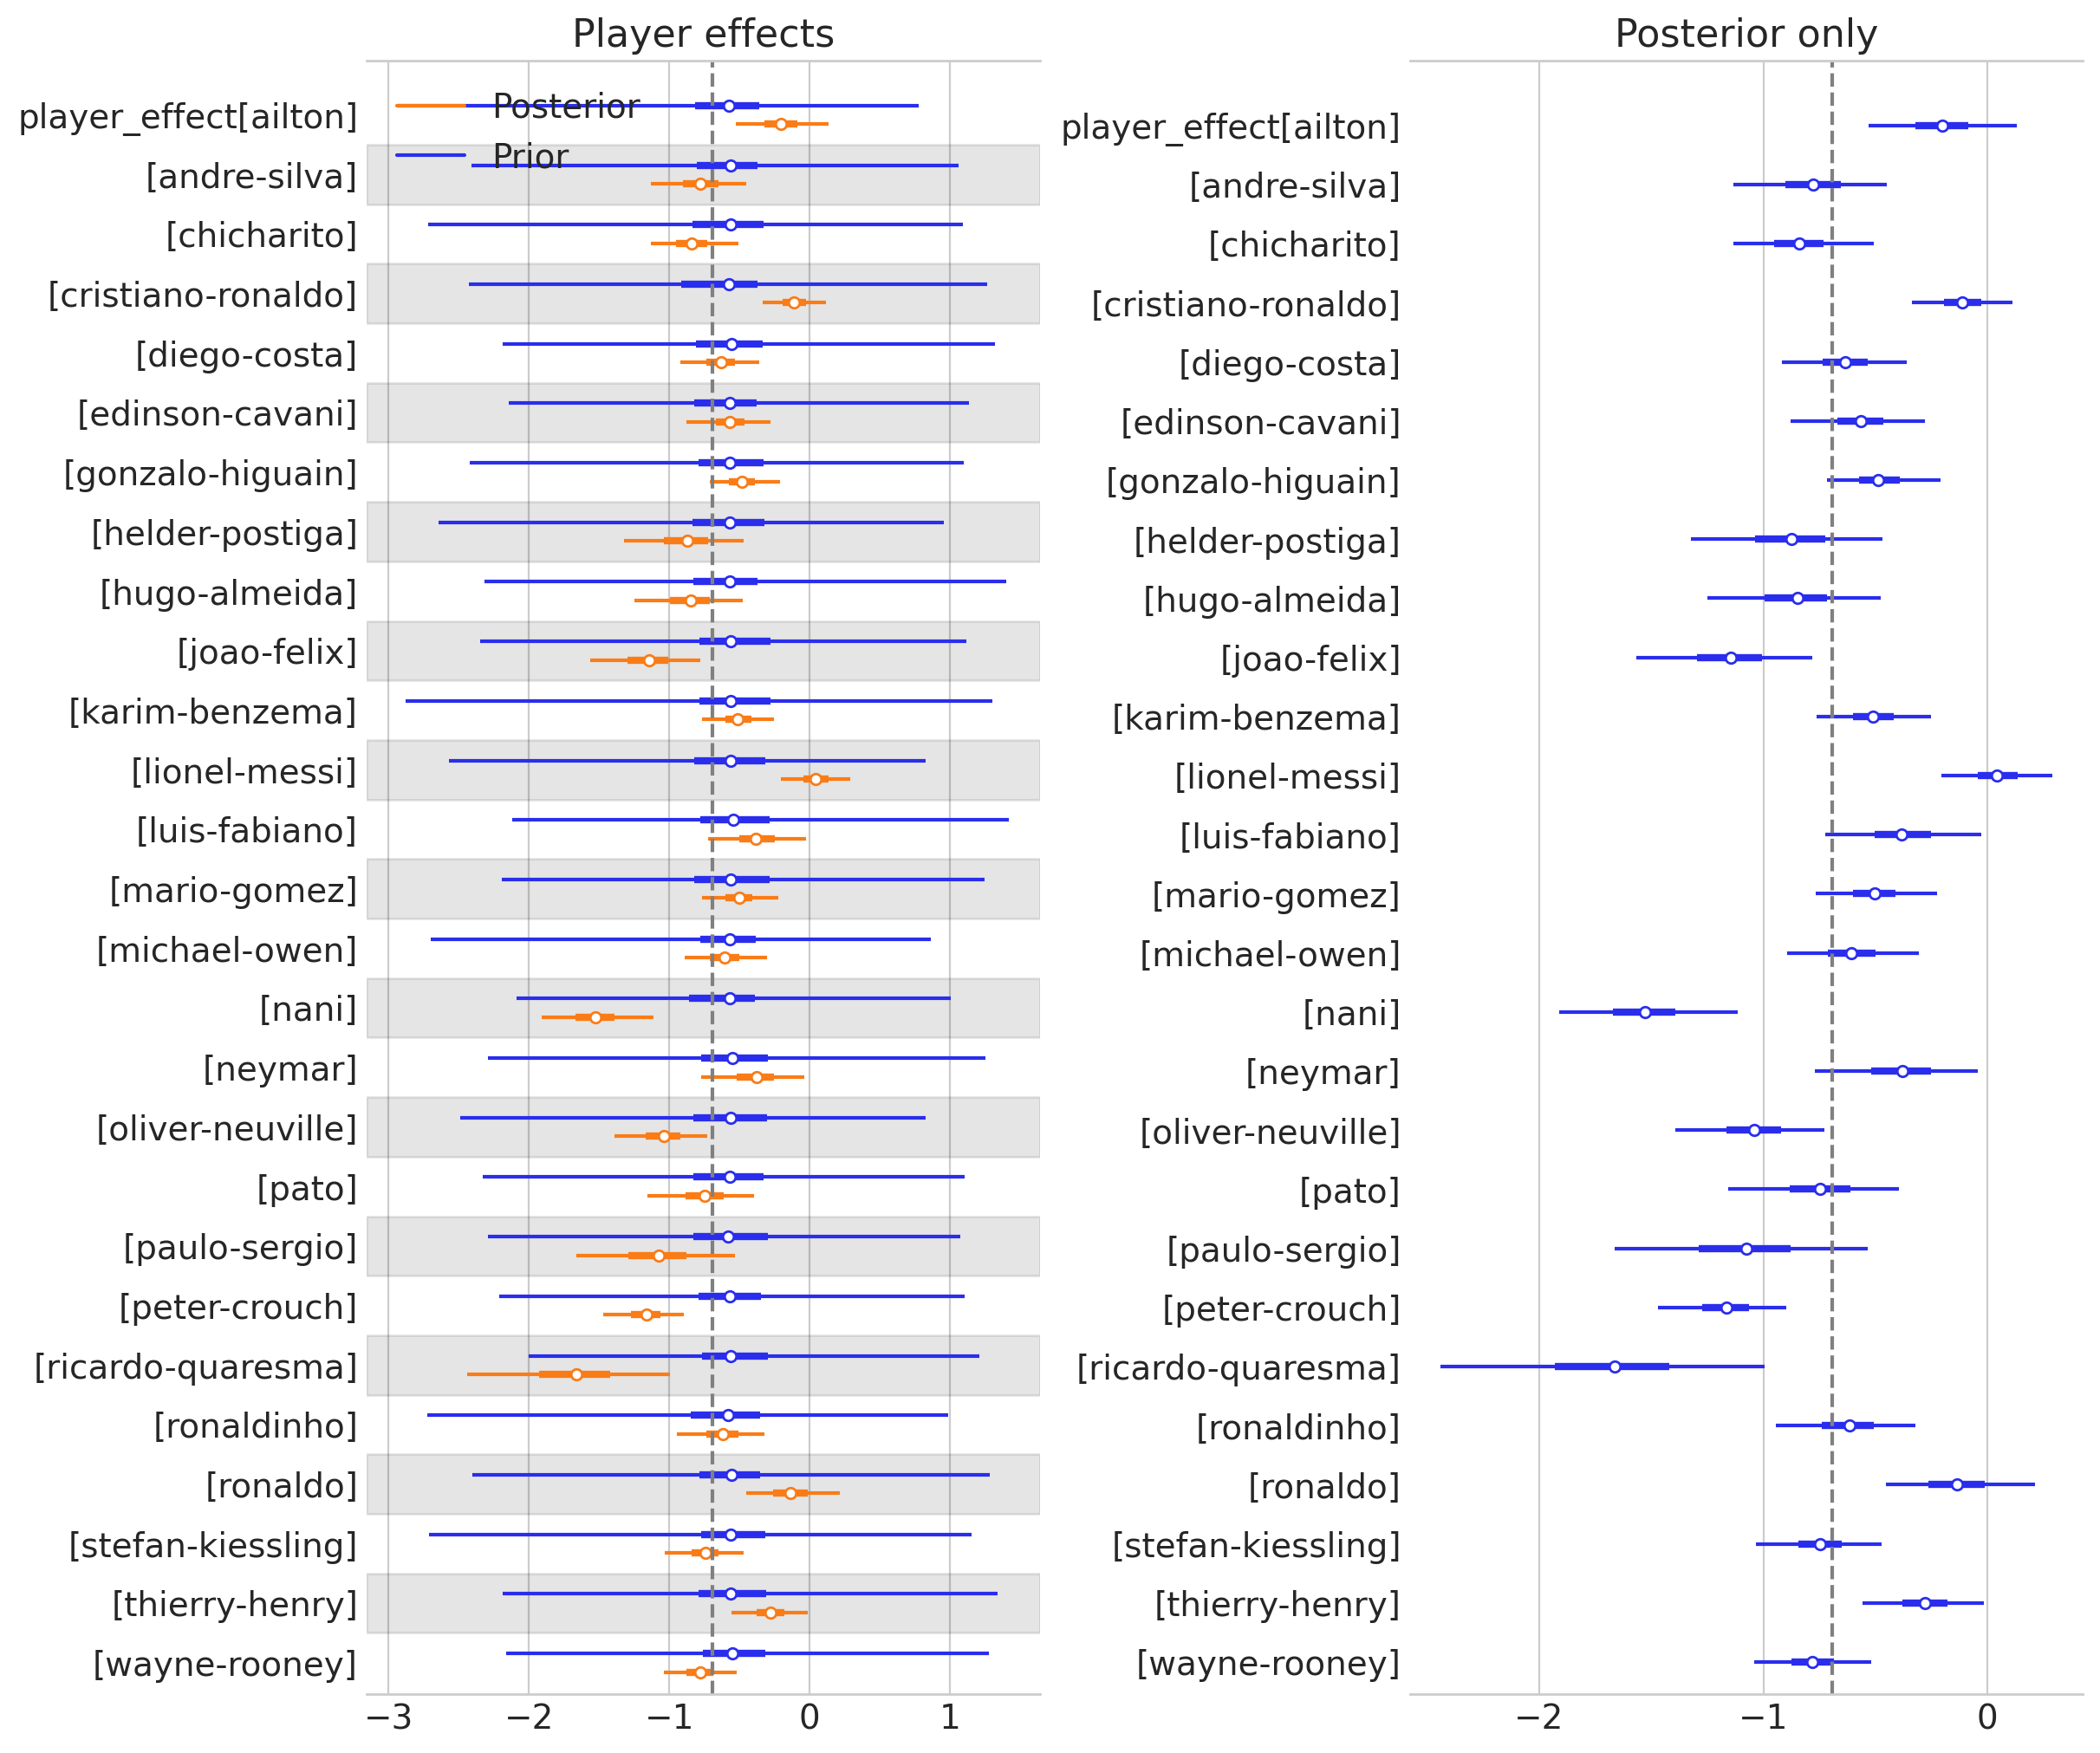

In [36]:
_, axes = plt.subplot_mosaic(
    """
    AB
    """,
    figsize=(12, 10),
    layout="constrained",
)

players_mean = idata.posterior.player_effect.mean()
az.plot_forest(
    [idata.prior, idata.posterior],
    model_names=["Prior", "Posterior"],
    var_names="player_effect",
    combined=True,
    ax=axes["A"],
)
axes["A"].axvline(x=players_mean, c="grey", ls="--")
axes["A"].set(title="Player effects")

az.plot_forest(
    idata,
    var_names="player_effect",
    combined=True,
    ax=axes["B"],
)
axes["B"].axvline(x=players_mean, c="grey", ls="--")
axes["B"].set(title="Posterior only");

## Posterior predictive checks

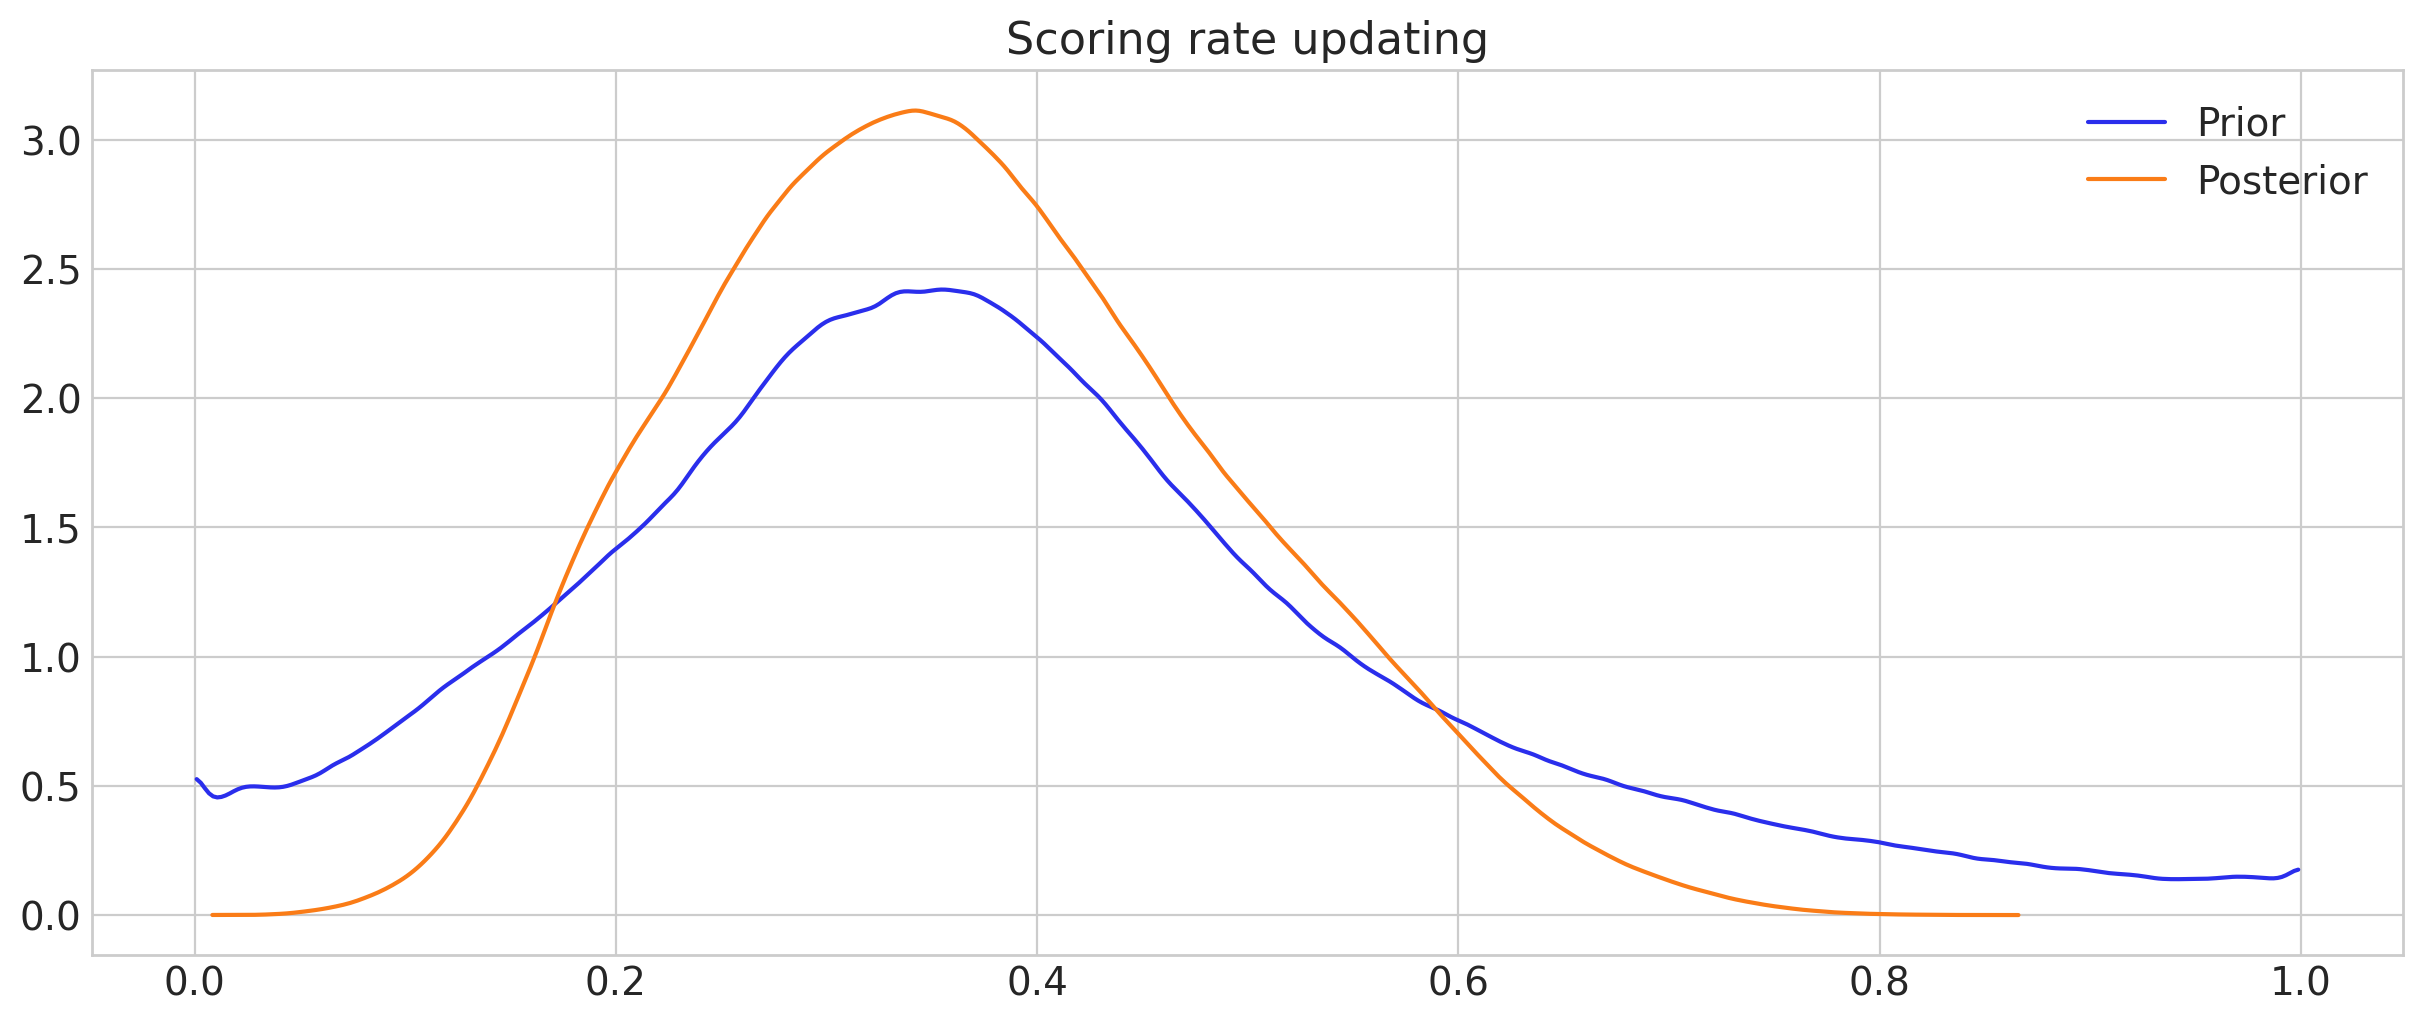

In [40]:
ax = az.plot_dist(idata.prior.p, label="Prior")
az.plot_dist(idata.posterior.p, ax=ax, color="C1", label="Posterior")
ax.set(title="Scoring rate updating");

## Performance evolution through time

In [44]:
f_long_post = idata.posterior["f_long"]
f_within_post = idata.posterior["f_within"]

f_long_post_aligned = f_long_post.sel(
    season=unique_combinations["season_nbr"].to_numpy()
).rename({"season": "timestamp"})
f_long_post_aligned["timestamp"] = unique_combinations.index

f_within_post_aligned = f_within_post.sel(
    gameday=unique_combinations["gameday"].to_numpy()
).rename({"gameday": "timestamp"})
f_within_post_aligned["timestamp"] = unique_combinations.index

f_total_post = f_long_post_aligned + f_within_post_aligned

some_draws = rng.choice(4000, size=20, replace=True)

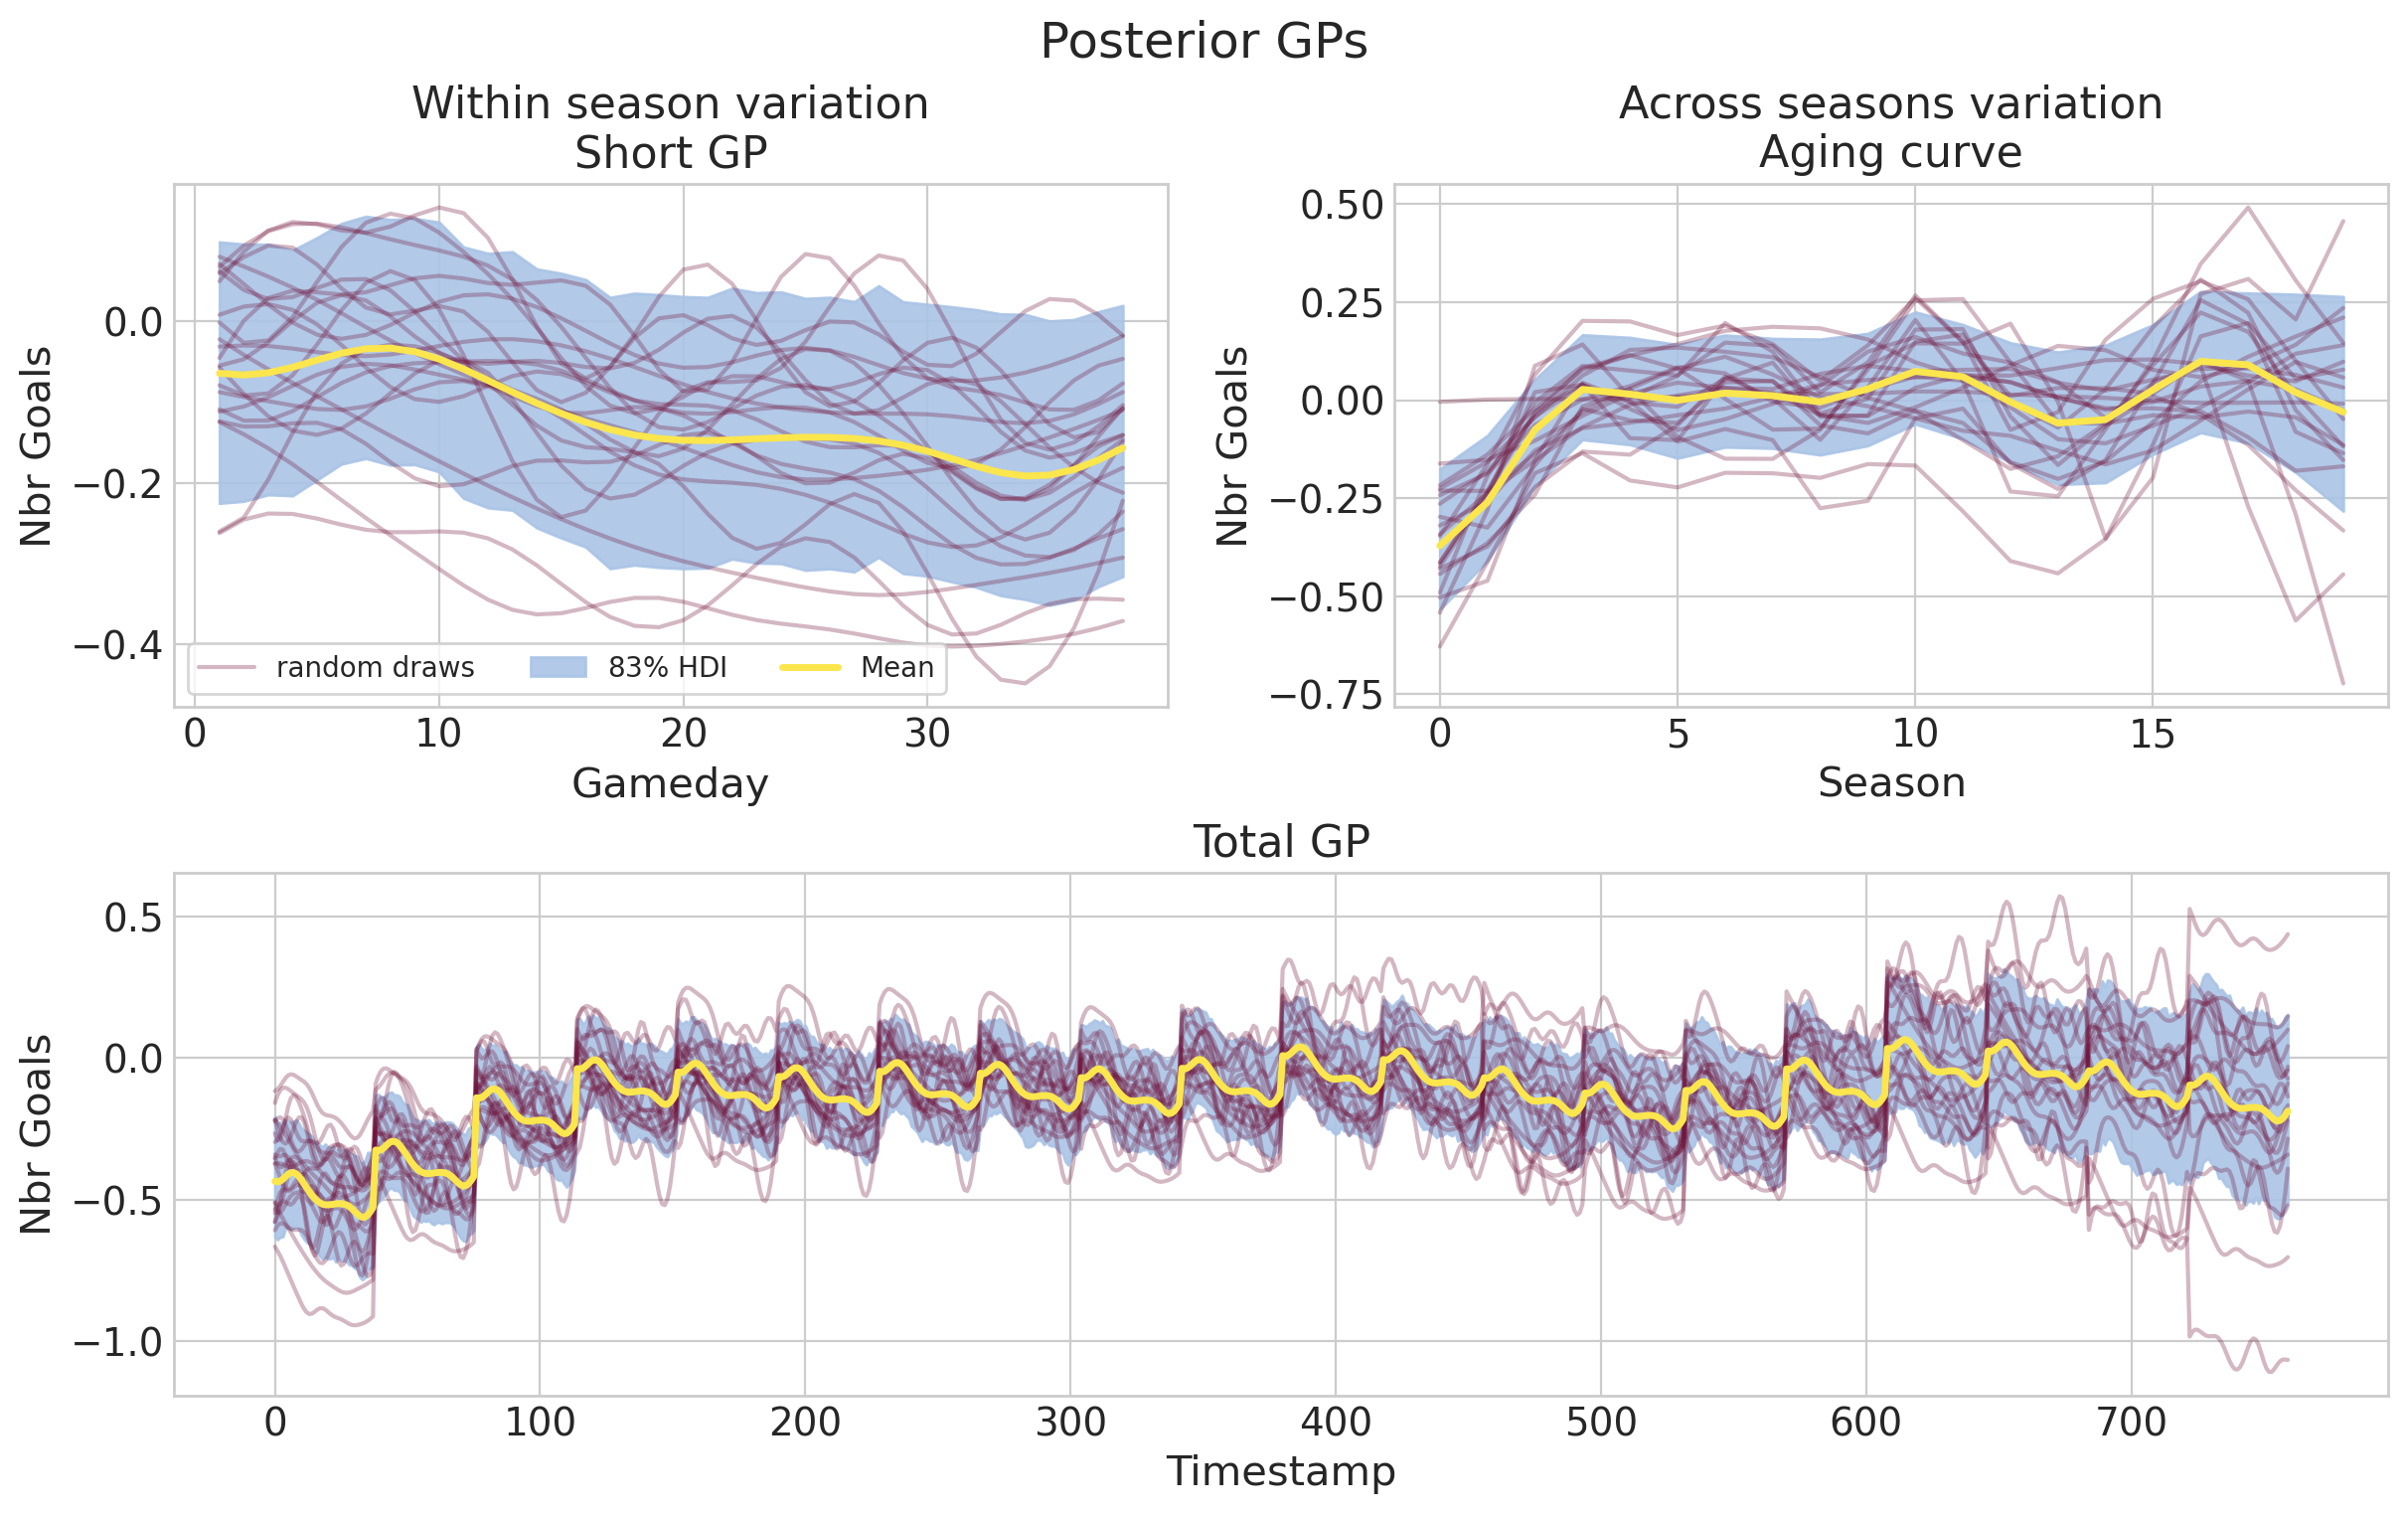

In [45]:
_, axes = plt.subplot_mosaic(
    """
    AB
    CC
    """,
    figsize=(12, 7.5),
    layout="constrained",
)

axes["A"].plot(
    f_within_post.gameday,
    az.extract(f_within_post)["f_within"].isel(sample=0),
    color="#70133A",
    alpha=0.3,
    lw=1.5,
    label="random draws",
)
axes["A"].plot(
    f_within_post.gameday,
    az.extract(f_within_post)["f_within"].isel(sample=some_draws),
    color="#70133A",
    alpha=0.3,
    lw=1.5,
)
az.plot_hdi(
    x=f_within_post.gameday,
    y=f_within_post,
    hdi_prob=0.83,
    color="#AAC4E6",
    fill_kwargs={"alpha": 0.9, "label": r"$83\%$ HDI"},
    ax=axes["A"],
    smooth=False,
)
axes["A"].plot(
    f_within_post.gameday,
    f_within_post.mean(("chain", "draw")),
    color="#FBE64D",
    lw=2.5,
    label="Mean",
)
axes["A"].set(
    xlabel="Gameday", ylabel="Nbr Goals", title="Within season variation\nShort GP"
)
axes["A"].legend(fontsize=10, frameon=True, ncols=3)

axes["B"].plot(
    f_long_post.season,
    az.extract(f_long_post)["f_long"].isel(sample=some_draws),
    color="#70133A",
    alpha=0.3,
    lw=1.5,
)
az.plot_hdi(
    x=f_long_post.season,
    y=f_long_post,
    hdi_prob=0.83,
    color="#AAC4E6",
    fill_kwargs={"alpha": 0.9},
    ax=axes["B"],
    smooth=False,
)
axes["B"].plot(
    f_long_post.season,
    f_long_post.mean(("chain", "draw")),
    color="#FBE64D",
    lw=2.5,
)
axes["B"].set(
    xlabel="Season", ylabel="Nbr Goals", title="Across seasons variation\nAging curve"
)

axes["C"].plot(
    f_total_post.timestamp,
    az.extract(f_total_post)["x"].isel(sample=some_draws),
    color="#70133A",
    alpha=0.3,
    lw=1.5,
)
az.plot_hdi(
    x=f_total_post.timestamp,
    y=f_total_post,
    hdi_prob=0.83,
    color="#AAC4E6",
    fill_kwargs={"alpha": 0.9},
    ax=axes["C"],
    smooth=False,
)
axes["C"].plot(
    f_total_post.timestamp,
    f_total_post.mean(("chain", "draw")),
    color="#FBE64D",
    lw=2.5,
)
axes["C"].set(xlabel="Timestamp", ylabel="Nbr Goals", title="Total GP")
plt.suptitle("Posterior GPs", fontsize=18);

## Summary: Soccer Player Skill Modeling

This case study demonstrated how to integrate multiple advanced GP techniques into a complete hierarchical model for sports analytics:

### The Factor Model Approach

We decomposed observed goal-scoring into interpretable components:

$$P(\text{goal}_{ij} = 1) = \text{logit}^{-1}(\alpha_i + f_{\text{within}}(t) + f_{\text{long}}(s) + \mathbf{X}_{ij}^T\boldsymbol{\beta})$$

- **$\alpha_i$**: Player-specific skill (hierarchical, partial pooling)
- **$f_{\text{within}}(t)$**: Within-season form (matchday-to-matchday via HSGP)
- **$f_{\text{long}}(s)$**: Long-term aging curve (across seasons via HSGP)
- **$\mathbf{X}_{ij}^T\boldsymbol{\beta}$**: Context factors (home advantage, momentum, opponent strength)

### Technical Integration

**Hierarchical structure**: Partial pooling via `pm.Normal` with learned `sigma` balances individual variation with population patterns

**Multi-scale temporal GPs**:
- Short-term (matchday): Matérn52 kernel with lengthscale ~5-25 days
- Long-term (seasons): Matérn52 kernel with lengthscale ~2-6 seasons
- Implemented with HSGP for computational scalability

**Non-Gaussian likelihood**: Bernoulli distribution for binary outcomes (goal/no goal)

**Maximum entropy priors**: Used PreliZ to encode domain knowledge (lengthscale bounds) while remaining minimally informative

### What This Enables

1. **Skill vs. context separation**: Identify truly skilled players after controlling for confounders
2. **Temporal dynamics**: Track within-season form fluctuations and across-season development/decline
3. **Uncertainty quantification**: Full posterior distributions over all parameters
4. **Interpretability**: Each model component has clear meaning in the domain

### The GP Toolkit Mastered (Sessions 1-4)

1. **Foundations** (Session 1): MVN → GP, kernels as covariance functions, marginal vs. latent
2. **Composition** (Session 2): Kernel addition/multiplication, non-Gaussian likelihoods
3. **Scaling** (Session 3): Computational bottlenecks, sparse approximations, HSGP
4. **Integration** (Sessions 4A-4B): Multi-output models, hierarchical structure, temporal dynamics

You're now equipped to apply Gaussian processes to complex real-world problems!